# Conclusion

XGBoost with kfolds=5, SMOTE oversampled, and pruned parameter values found with `RandomizedSearchCV`.

Worse results than guessing.


In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from datasets import data as Local ## Local module to get dataframes

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
games_df, winners_df, greater_fgp_df, greater_fg3_df, greater_ft_df, greater_ast_df, greater_reb_df, cumulative_stats_df, games_details_df, teams_df, players_df, ranking_df = \
    Local.get_all_dataset_dataframes('../../datasets/')

# Target datasets

- Home has:
    - 59.1% Winrate
    - 55.0% Rate of Higher FGP
    - 50.8% Rate of Higher FG3
    - 49.5% Rate of Higher FTP
    - 55.0% Rate of Higher AST
    - 53.4% Rate of Higher REB

In [3]:
winners_df # Whether the home team won in a game in each row of `games_df`

16157    1
16156    1
16155    1
16154    1
16153    1
        ..
4        0
3        0
2        0
1        1
0        1
Name: HOME_TEAM_WINS, Length: 23520, dtype: int64

In [4]:
winners_df.describe()

count    23520.000000
mean         0.591029
std          0.491654
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_TEAM_WINS, dtype: float64

In [5]:
greater_fgp_df.describe()

count    23520.000000
mean         0.550468
std          0.497457
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FG_PCT, dtype: float64

In [6]:
greater_fg3_df.describe()

count    23520.000000
mean         0.507993
std          0.499947
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FG3_PCT, dtype: float64

In [7]:
greater_ft_df.describe()

count    23520.000000
mean         0.494855
std          0.499984
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FT_PCT, dtype: float64

In [8]:
greater_ast_df.describe()

count    23520.000000
mean         0.550128
std          0.497491
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_AST, dtype: float64

In [9]:
greater_reb_df.describe()

count    23520.000000
mean         0.533886
std          0.498861
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_REB, dtype: float64

# Datasets

In [10]:
games_df

GAME_DATE_EST   GAME_ID  HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON  \
16157    2003-10-05  10300001    1610612762       1610612742    2003   
16156    2003-10-06  10300002    1610612763       1610612749    2003   
16155    2003-10-07  10300009    1610612758       1610612746    2003   
16154    2003-10-07  10300005    1610612757       1610612745    2003   
16153    2003-10-07  10300007    1610612748       1610612755    2003   
...             ...       ...           ...              ...     ...   
4        2020-12-18  12000040    1610612761       1610612748    2020   
3        2020-12-18  12000039    1610612754       1610612755    2020   
2        2020-12-19  12000049    1610612763       1610612737    2020   
1        2020-12-19  12000048    1610612764       1610612765    2020   
0        2020-12-19  12000047    1610612753       1610612766    2020   

       PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  REB_home  \
16157      90.0        0.457        0.735         0.143      23.0      41.0   
16156     105.0        0.494        0.618         0.267      25.0      48.0   
16155     101.0        0.467        0.871         0.444      19.0      39.0   
16154     104.0        0.527        0.657         0.429      22.0      33.0   
16153      86.0        0.352        0.647         0.222      15.0      55.0   
...         ...          ...          ...           ...       ...       ...   
4         105.0        0.380        0.737         0.356      27.0      37.0   
3         107.0        0.371        0.692         0.262      19.0      45.0   
2         116.0        0.400        0.744         0.396      21.0      43.0   
1          99.0        0.427        0.625         0.295      24.0      45.0   
0         120.0        0.433        0.792         0.425      23.0      50.0   

       PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  REB_away  
16157      85.0        0.447        0.500         0.250      20.0      38.0  
16156      94.0        0.427        0.700         0.154      20.0      43.0  
16155      82.0        0.368        0.609         0.364      13.0      50.0  
16154      80.0        0.470        0.667         0.333      10.0      37.0  
16153      79.0        0.329        0.897         0.143       7.0      44.0  
...         ...          ...          ...           ...       ...       ...  
4         117.0        0.534        0.741         0.514      30.0      51.0  
3         113.0        0.533        0.629         0.355      23.0      48.0  
2         117.0        0.422        0.837         0.297      24.0      47.0  
1          96.0        0.402        0.647         0.326      18.0      51.0  
0         117.0        0.444        0.864         0.439      21.0      52.0  

[23520 rows x 17 columns]

In [11]:
cumulative_stats_df

DATE   GAME_ID  SEASON_TYPE  SEASON  GAMES_PLAYED_home  \
0      2003-10-05  10300001            1    2003                  0   
1      2003-10-06  10300002            1    2003                  0   
2      2003-10-07  10300009            1    2003                  0   
3      2003-10-07  10300005            1    2003                  0   
4      2003-10-07  10300007            1    2003                  0   
...           ...       ...          ...     ...                ...   
23515  2020-12-18  12000040            1    2020                  2   
23516  2020-12-18  12000039            1    2020                  2   
23517  2020-12-19  12000049            1    2020                  3   
23518  2020-12-19  12000048            1    2020                  2   
23519  2020-12-19  12000047            1    2020                  3   

       GAMES_PLAYED_away  PPG_total_home  FG_PCT_total_home  \
0                      0        0.000000           0.000000   
1                      0        0.000000           0.000000   
2                      0        0.000000           0.000000   
3                      0        0.000000           0.000000   
4                      0        0.000000           0.000000   
...                  ...             ...                ...   
23515                  1      111.500000           0.443500   
23516                  1      105.000000           0.438000   
23517                  3      119.333333           0.466667   
23518                  3      100.000000           0.415000   
23519                  3      112.666667           0.444333   

       FG3_PCT_total_home  FT_PCT_total_home  ...  PPG_total_away  \
0                0.000000           0.000000  ...        0.000000   
1                0.000000           0.000000  ...        0.000000   
2                0.000000           0.000000  ...        0.000000   
3                0.000000           0.000000  ...        0.000000   
4                0.000000           0.000000  ...        0.000000   
...                   ...                ...  ...             ...   
23515            0.353000           0.691000  ...       92.000000   
23516            0.383000           0.619000  ...      108.000000   
23517            0.329333           0.704667  ...      111.333333   
23518            0.321500           0.704500  ...       93.333333   
23519            0.305333           0.758000  ...      110.666667   

       FG_PCT_total_away  FG3_PCT_total_away  FT_PCT_total_away  \
0               0.000000            0.000000           0.000000   
1               0.000000            0.000000           0.000000   
2               0.000000            0.000000           0.000000   
3               0.000000            0.000000           0.000000   
4               0.000000            0.000000           0.000000   
...                  ...                 ...                ...   
23515           0.427000            0.283000           0.818000   
23516           0.471000            0.241000           0.750000   
23517           0.392667            0.332333           0.789667   
23518           0.413333            0.333000           0.713000   
23519           0.442333            0.372333           0.751000   

       APG_total_away  RPG_total_away  TEAM_ID_away  TEAM_ID_home  W_PCT_away  \
0            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
1            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
2            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
3            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
4            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
...               ...             ...           ...           ...         ...   
23515       26.000000       35.000000  1.610613e+09  1.610613e+09    0.000000   
23516       23.000000       42.000000  1.610613e+09  1.610613e+09    1.000000   
23517       24.000000       56.000000  1

## Attach target columns to dataset

In [12]:
cumulative_stats_copy_df = cumulative_stats_df.copy()
cumulative_stats_copy_df['home_win'] = winners_df
cumulative_stats_copy_df['greater_fgp'] = greater_fgp_df
cumulative_stats_copy_df['greater_fg3'] = greater_fg3_df
cumulative_stats_copy_df['greater_ft'] = greater_ft_df
cumulative_stats_copy_df['greater_ast'] = greater_ast_df
cumulative_stats_copy_df['greater_reb'] = greater_reb_df

## Remove rows w/o data

In [13]:
cumulative_stats_copy_df = cumulative_stats_copy_df[(cumulative_stats_copy_df['GAMES_PLAYED_home']>0) & (cumulative_stats_copy_df['GAMES_PLAYED_away']>0)]

# Get new target datasets after row removal
winners_df = cumulative_stats_copy_df['home_win']
greater_fgp_df = cumulative_stats_copy_df['greater_fgp']
greater_fg3_df = cumulative_stats_copy_df['greater_fg3']
greater_ft_df = cumulative_stats_copy_df['greater_ft']
greater_ast_df = cumulative_stats_copy_df['greater_ast']
greater_reb_df = cumulative_stats_copy_df['greater_reb']

## Remove non-data

In [14]:
# Delete non-data
for key in [
    'DATE','GAME_ID','TEAM_ID_home','TEAM_ID_away','SEASON_TYPE','SEASON','GAMES_PLAYED_home','GAMES_PLAYED_away',
    'home_win','greater_fgp','greater_fg3','greater_ft','greater_ast','greater_reb'
]:
    del cumulative_stats_copy_df[key]
# Only look at home teams
# cumulative_stats_copy_df = cumulative_stats_copy_df.loc[cumulative_stats_copy_df['AT_HOME']==True]
# del cumulative_stats_copy_df['AT_HOME']
cumulative_stats_copy_df

PPG_total_home  FG_PCT_total_home  FG3_PCT_total_home  \
19         104.000000           0.527000            0.429000   
21          86.000000           0.380000            0.188000   
22          86.000000           0.352000            0.222000   
23          58.000000           0.457000            0.667000   
24          87.500000           0.432000            0.420000   
...               ...                ...                 ...   
23515      111.500000           0.443500            0.353000   
23516      105.000000           0.438000            0.383000   
23517      119.333333           0.466667            0.329333   
23518      100.000000           0.415000            0.321500   
23519      112.666667           0.444333            0.305333   

       FT_PCT_total_home  APG_total_home  RPG_total_home  PPG_total_away  \
19              0.657000       22.000000       33.000000      101.000000   
21              0.852000       19.000000       37.000000      101.000000   
22              0.647000       15.000000       55.000000       80.000000   
23              0.700000       10.000000       31.000000       89.000000   
24              0.672000       20.500000       43.000000       79.000000   
...                  ...             ...             ...             ...   
23515           0.691000       25.000000       41.500000       92.000000   
23516           0.619000       26.000000       35.500000      108.000000   
23517           0.704667       30.666667       52.666667      111.333333   
23518           0.704500       22.000000       44.500000       93.333333   
23519           0.758000       25.000000       51.333333      110.666667   

       FG_PCT_total_away  FG3_PCT_total_away  FT_PCT_total_away  \
19              0.467000            0.444000           0.871000   
21              0.464000            0.250000           0.679000   
22              0.350000            0.429000           0.750000   
23              0.462000            0.214000           0.538000   
24              0.329000            0.143000           0.897000   
...                  ...                 ...                ...   
23515           0.427000            0.283000           0.818000   
23516           0.471000            0.241000           0.750000   
23517           0.392667            0.332333           0.789667   
23518           0.413333            0.333000           0.713000   
23519           0.442333            0.372333           0.751000   

       APG_total_away  RPG_total_away  W_PCT_away  W_PCT_home  
19          19.000000       39.000000    1.000000    1.000000  
21          22.000000       47.000000    1.000000    0.000000  
22          18.000000       45.000000    0.000000    1.000000  
23          21.000000       36.000000    0.000000    0.000000  
24           7.000000       44.000000    0.000000    0.500000  
...               ...             ...         ...         ...  
23515       26.000000       35.000000    0.000000    1.000000  
23516       23.000000       42.000000    1.000000    0.000000  
23517       24.000000       56.000000    0.333333    1.000000  
23518       20.000000       41.666667    0.666667    0.000000  
23519       29.666667       45.000000    0.333333    0.333333  

[23147 rows x 14 columns]

## Do hyperparameters searches

In [15]:
from sklearn.metrics import classification_report

In [16]:
from sklearn.tree import plot_tree
from yellowbrick.model_selection import FeatureImportances

In [17]:
from sklearn.utils.class_weight import compute_sample_weight

In [18]:
# Get best params based from CV function
def do_cv(classifier, cv_fun, params, x, y, **kwargs):
    clf = cv_fun(
        classifier,
        params,
        scoring='accuracy', # Optimize for the 'accuracy' score of the model.
        **kwargs,
    )
#     clf.fit(x, y, sample_weight=compute_sample_weight('balanced',y))
    clf.fit(x, y)
    return clf

## Plot feature importances

In [19]:
def plot_feature_importances(clf, X, y):
    viz = FeatureImportances(clf, labels=X.columns)
    viz.fit(X, y)
    viz.show()

In [20]:
def print_all_metrics_and_plot(clf, X_train_dict, X_test_dict, y_train_dict, y_test_dict, grid_cv_params):
    scores = []
    for key in X_train_dict.keys():
        cv_clf = do_cv(
            clf,
#             GridSearchCV,
            RandomizedSearchCV,
            grid_cv_params,
            X_train_dict[key],
            y_train_dict[key],
        )
        print(key.upper()+':\n')
        score = cv_clf.best_estimator_.score(X_test_dict[key], y_test_dict[key])
        scores.append(score)
        print('Best XGBoost accuracy (%s): %.2f' % (str(cv_clf.best_params_), score))
        print(classification_report(y_test_dict[key], cv_clf.best_estimator_.predict(X_test_dict[key])))
        plot_feature_importances(cv_clf.best_estimator_, X_train_dict[key], y_train_dict[key])
        print('---------------------------------------------')
    return scores

## Build K-folds datasets

In [21]:
from imblearn.over_sampling import SMOTE

In [22]:
from sklearn.model_selection import KFold
kf = KFold(shuffle=True, random_state=123)

X_train_dicts = []
X_test_dicts = []
y_train_dicts = []
y_test_dicts = []

for target, key in [(winners_df, 'winner'), (greater_fgp_df, 'fgp'), (greater_fg3_df, 'fg3'), (greater_ft_df, 'ft'), (greater_ast_df, 'ast'), (greater_reb_df, 'reb')]:
    X_over, y_over = SMOTE(sampling_strategy='minority').fit_resample(cumulative_stats_copy_df, target)
    for train, test in kf.split(X_over, y_over):
        X_train_dict = {}
        X_test_dict = {}
        y_train_dict = {}
        y_test_dict = {}
        
        X_train_dict[key], X_test_dict[key] = X_over.iloc[train], X_over.iloc[test]
        y_train_dict[key], y_test_dict[key] = y_over.iloc[train], y_over.iloc[test]
        
        X_train_dicts.append(X_train_dict)
        X_test_dicts.append(X_test_dict)
        y_train_dicts.append(y_train_dict)
        y_test_dicts.append(y_test_dict)

assert len(X_train_dicts)==len(X_test_dicts)==len(y_train_dicts)==len(y_test_dicts)
print(len(X_train_dicts))

30


In [23]:
def print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, params):
    scores=[]
    for i in range(len(X_train_dicts)):
        print(f'i={i}')
        score = print_all_metrics_and_plot(
            xgb.XGBClassifier(random_state=0,eval_metric='logloss'),
            X_train_dicts[i],
            X_test_dicts[i],
            y_train_dicts[i],
            y_test_dicts[i],
            params,
        )
        if (i+1)%5==0:
            scores = pd.DataFrame(np.array(scores))
            print(f'Mean accuracy: {scores.mean()[0]}')
            print(f'Max accuracy: {scores.max()[0]}')
            print(f'Min accuracy: {scores.min()[0]}')
            print('=========================================')
            scores=[]
        else:
            scores += score

## Train w/o pruning

In [24]:
import warnings
warnings.filterwarnings("ignore")

i=0
WINNER:

Best XGBoost accuracy ({}): 0.55
              precision    recall  f1-score   support

           0       0.54      0.58      0.56      2695
           1       0.56      0.53      0.55      2789

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



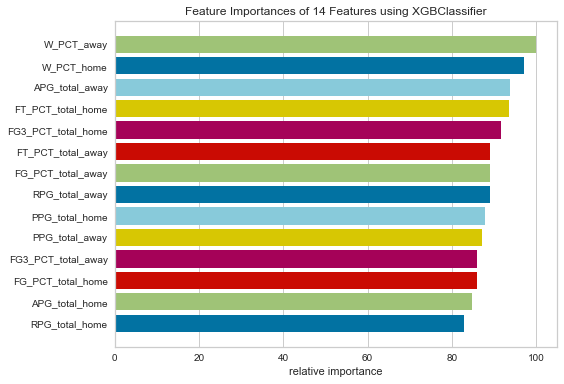

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({}): 0.56
              precision    recall  f1-score   support

           0       0.56      0.58      0.57      2780
           1       0.55      0.54      0.55      2704

    accuracy                           0.56      5484
   macro avg       0.56      0.56      0.56      5484
weighted avg       0.56      0.56      0.56      5484



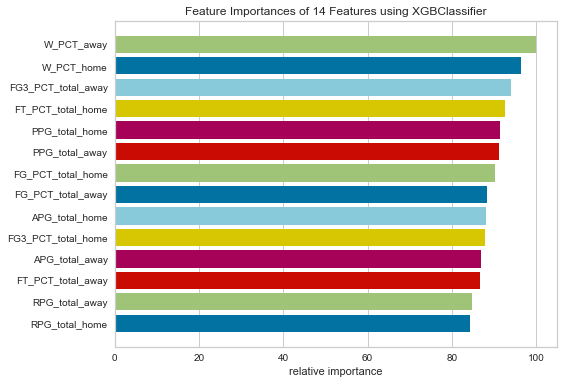

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      2727
           1       0.55      0.52      0.54      2757

    accuracy                           0.54      5484
   macro avg       0.54      0.54      0.54      5484
weighted avg       0.54      0.54      0.54      5484



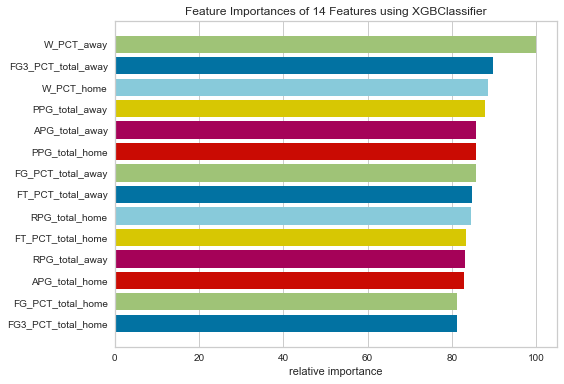

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({}): 0.56
              precision    recall  f1-score   support

           0       0.55      0.58      0.57      2715
           1       0.57      0.54      0.55      2768

    accuracy                           0.56      5483
   macro avg       0.56      0.56      0.56      5483
weighted avg       0.56      0.56      0.56      5483



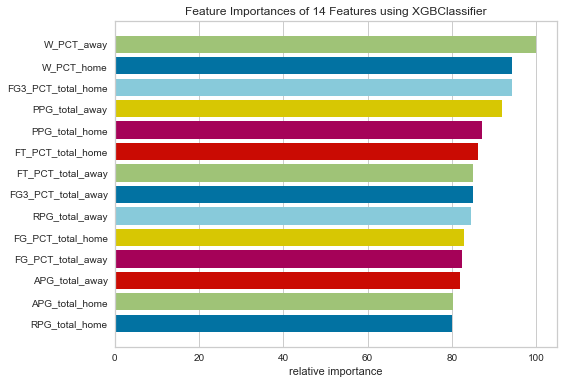

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({}): 0.55
              precision    recall  f1-score   support

           0       0.56      0.57      0.56      2792
           1       0.54      0.54      0.54      2691

    accuracy                           0.55      5483
   macro avg       0.55      0.55      0.55      5483
weighted avg       0.55      0.55      0.55      5483



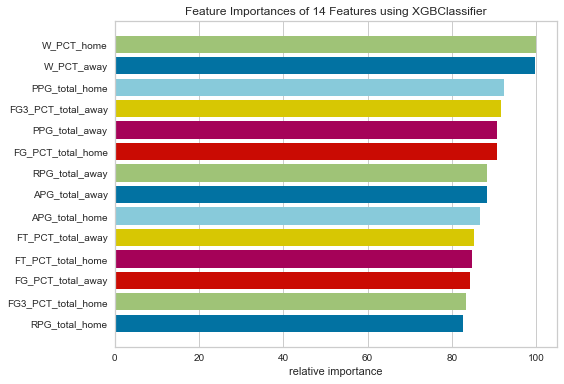

---------------------------------------------
Mean accuracy: 0.5539552047552856
Max accuracy: 0.561371511946015
Min accuracy: 0.5428519328956966
i=5
FGP:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.54      0.53      0.53      2614
           1       0.51      0.52      0.52      2495

    accuracy                           0.52      5109
   macro avg       0.52      0.52      0.52      5109
weighted avg       0.53      0.52      0.53      5109



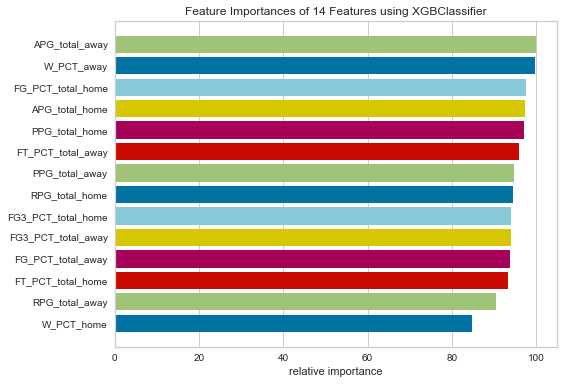

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.54      0.54      2571
           1       0.53      0.52      0.52      2538

    accuracy                           0.53      5109
   macro avg       0.53      0.53      0.53      5109
weighted avg       0.53      0.53      0.53      5109



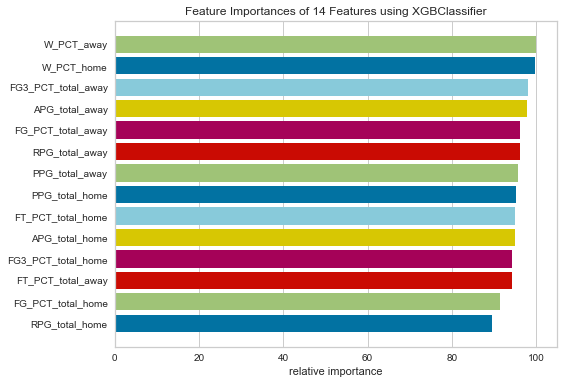

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2559
           1       0.53      0.52      0.53      2549

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



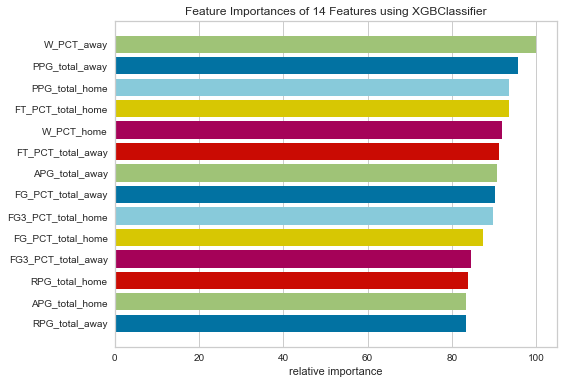

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({}): 0.53
              precision    recall  f1-score   support

           0       0.51      0.56      0.54      2470
           1       0.55      0.50      0.52      2638

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



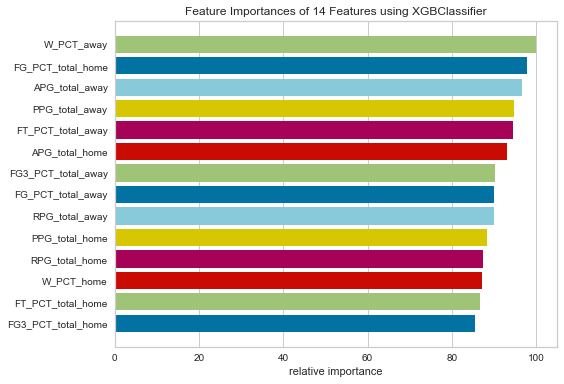

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.54      0.53      2557
           1       0.53      0.51      0.52      2551

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



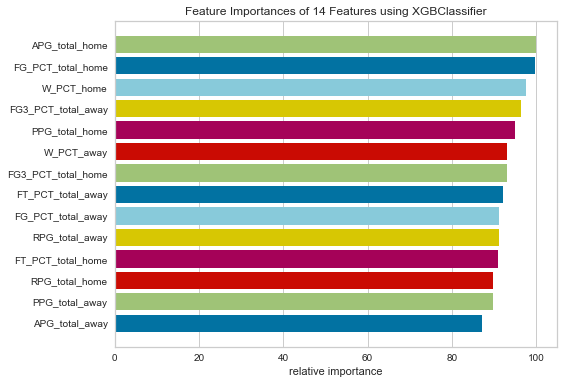

---------------------------------------------
Mean accuracy: 0.5278947813928865
Max accuracy: 0.5307361002349256
Min accuracy: 0.5249559600704639
i=10
FG3:

Best XGBoost accuracy ({}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      2365
           1       0.50      0.51      0.50      2346

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



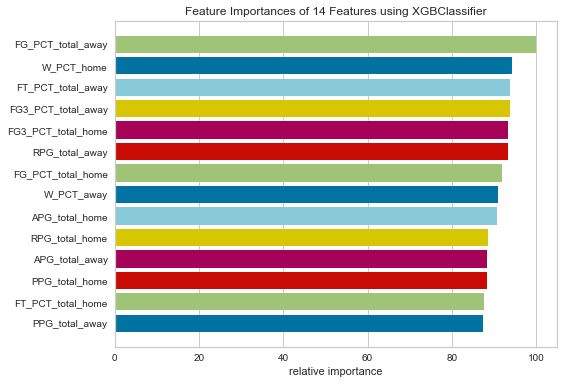

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({}): 0.49
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      2402
           1       0.48      0.50      0.49      2309

    accuracy                           0.49      4711
   macro avg       0.49      0.49      0.49      4711
weighted avg       0.49      0.49      0.49      4711



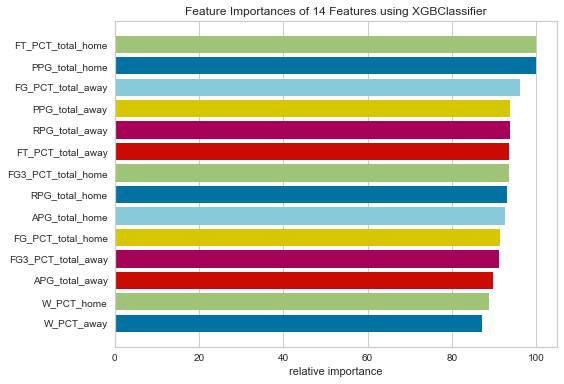

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.53      0.51      2284
           1       0.53      0.50      0.51      2427

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



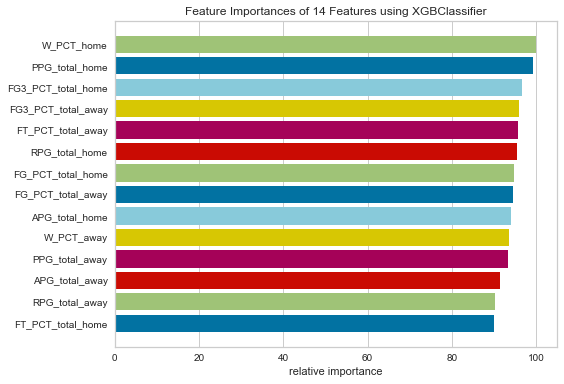

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({}): 0.49
              precision    recall  f1-score   support

           0       0.48      0.51      0.50      2307
           1       0.50      0.47      0.49      2404

    accuracy                           0.49      4711
   macro avg       0.49      0.49      0.49      4711
weighted avg       0.49      0.49      0.49      4711



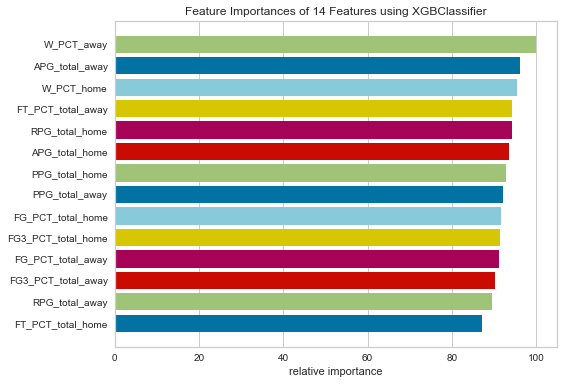

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      2419
           1       0.49      0.50      0.50      2291

    accuracy                           0.51      4710
   macro avg       0.51      0.51      0.51      4710
weighted avg       0.51      0.51      0.51      4710



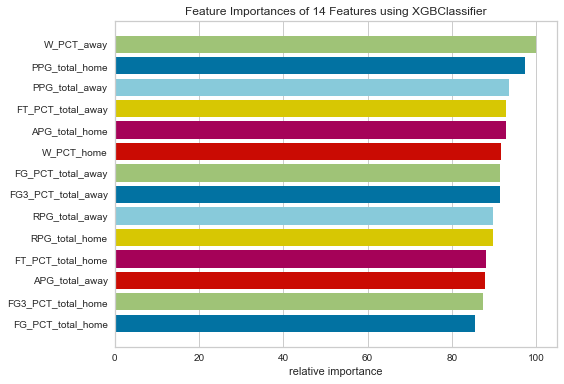

---------------------------------------------
Mean accuracy: 0.49978773084270856
Max accuracy: 0.5115686690723837
Min accuracy: 0.49203990660157076
i=15
FT:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2337
           1       0.51      0.52      0.52      2345

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



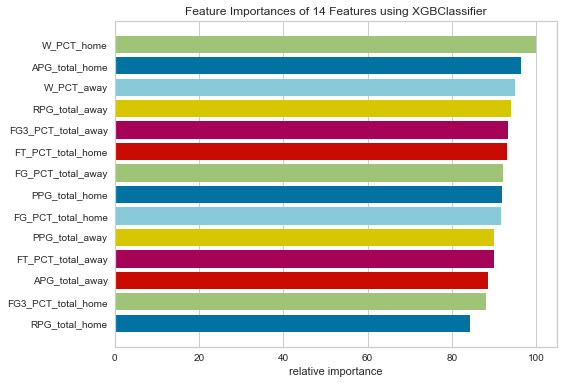

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2322
           1       0.51      0.50      0.50      2360

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



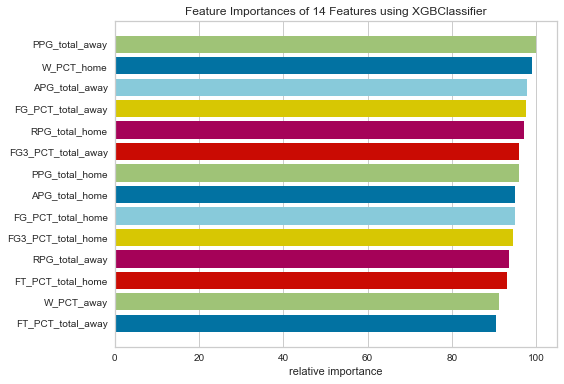

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({}): 0.49
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2360
           1       0.49      0.48      0.48      2322

    accuracy                           0.49      4682
   macro avg       0.49      0.49      0.49      4682
weighted avg       0.49      0.49      0.49      4682



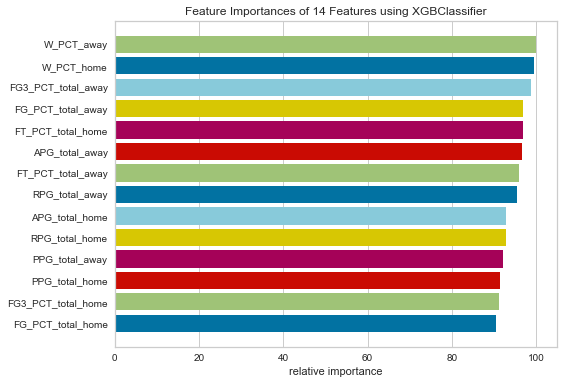

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      2343
           1       0.51      0.51      0.51      2339

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



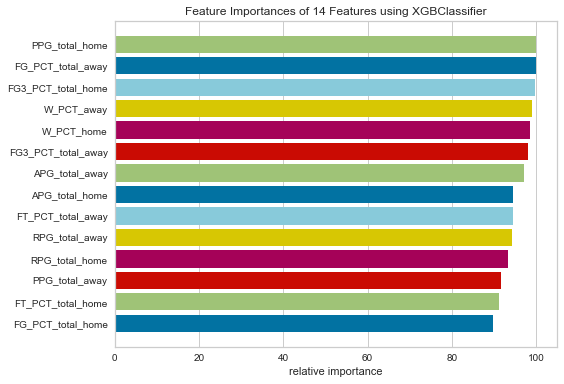

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2343
           1       0.52      0.53      0.52      2339

    accuracy                           0.52      4682
   macro avg       0.52      0.52      0.52      4682
weighted avg       0.52      0.52      0.52      4682



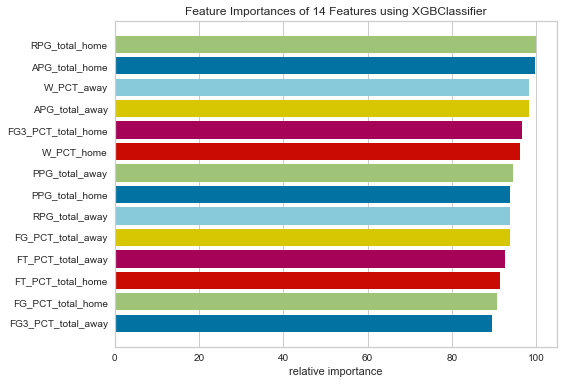

---------------------------------------------
Mean accuracy: 0.502402819307988
Max accuracy: 0.5089705254164887
Min accuracy: 0.49209739427595045
i=20
AST:

Best XGBoost accuracy ({}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.54      0.54      2556
           1       0.53      0.52      0.52      2540

    accuracy                           0.53      5096
   macro avg       0.53      0.53      0.53      5096
weighted avg       0.53      0.53      0.53      5096



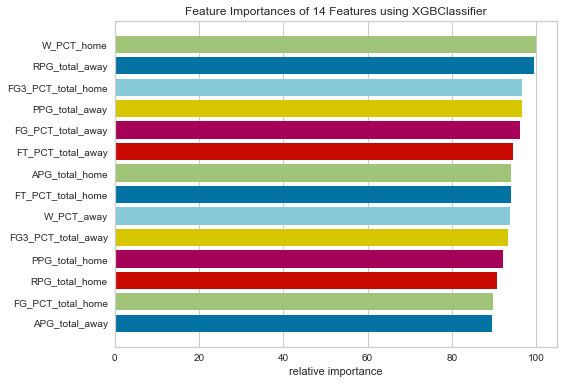

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.52      0.52      2578
           1       0.51      0.52      0.52      2517

    accuracy                           0.52      5095
   macro avg       0.52      0.52      0.52      5095
weighted avg       0.52      0.52      0.52      5095



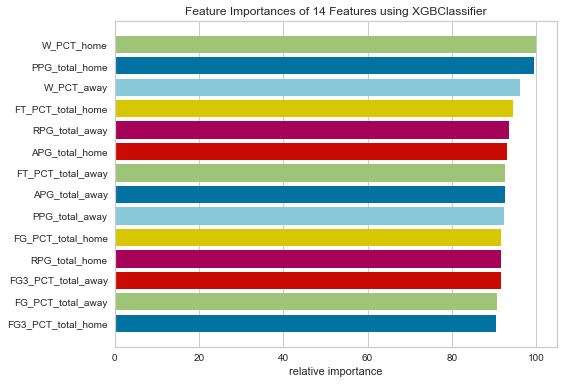

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({}): 0.53
              precision    recall  f1-score   support

           0       0.52      0.55      0.54      2522
           1       0.54      0.51      0.52      2573

    accuracy                           0.53      5095
   macro avg       0.53      0.53      0.53      5095
weighted avg       0.53      0.53      0.53      5095



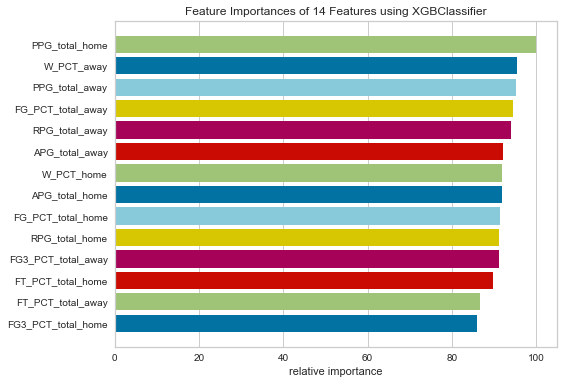

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({}): 0.53
              precision    recall  f1-score   support

           0       0.52      0.55      0.54      2531
           1       0.53      0.50      0.52      2564

    accuracy                           0.53      5095
   macro avg       0.53      0.53      0.53      5095
weighted avg       0.53      0.53      0.53      5095



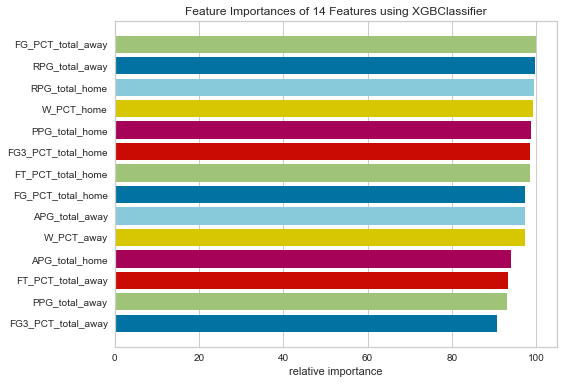

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      2551
           1       0.52      0.50      0.51      2544

    accuracy                           0.52      5095
   macro avg       0.52      0.52      0.52      5095
weighted avg       0.52      0.52      0.52      5095



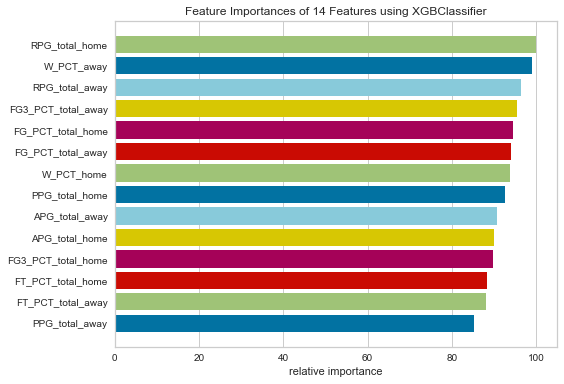

---------------------------------------------
Mean accuracy: 0.5268140418392767
Max accuracy: 0.530323846908734
Min accuracy: 0.5201177625122669
i=25
REB:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      2470
           1       0.52      0.50      0.51      2475

    accuracy                           0.52      4945
   macro avg       0.52      0.52      0.52      4945
weighted avg       0.52      0.52      0.52      4945



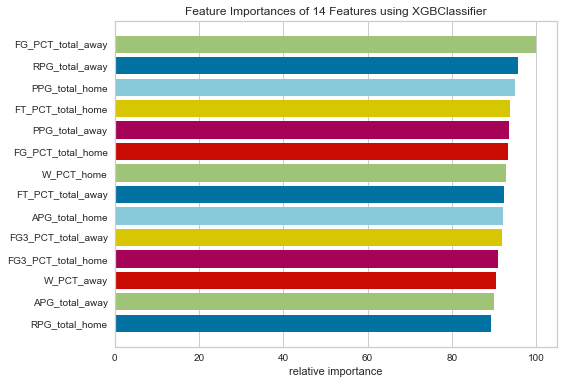

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.51      0.54      0.52      2413
           1       0.53      0.51      0.52      2532

    accuracy                           0.52      4945
   macro avg       0.52      0.52      0.52      4945
weighted avg       0.52      0.52      0.52      4945



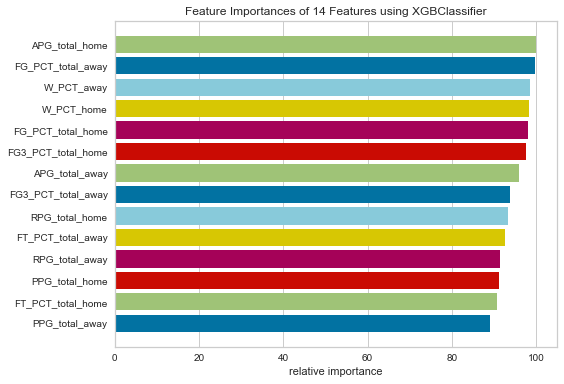

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.53      0.53      2479
           1       0.52      0.51      0.51      2465

    accuracy                           0.52      4944
   macro avg       0.52      0.52      0.52      4944
weighted avg       0.52      0.52      0.52      4944



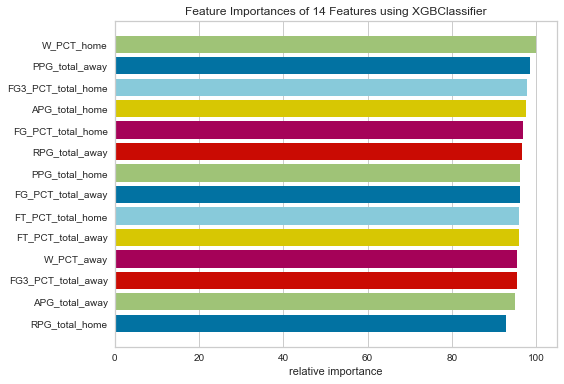

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2473
           1       0.51      0.51      0.51      2471

    accuracy                           0.51      4944
   macro avg       0.51      0.51      0.51      4944
weighted avg       0.51      0.51      0.51      4944



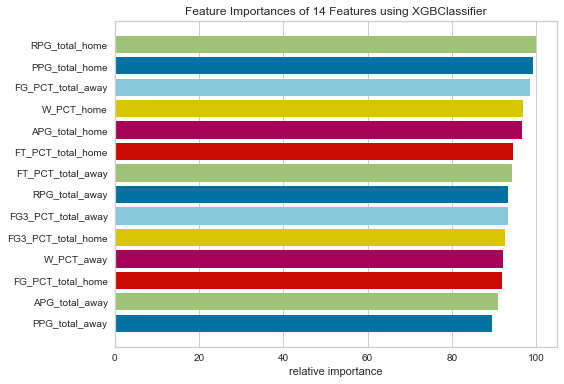

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.50      0.52      2526
           1       0.51      0.53      0.52      2418

    accuracy                           0.52      4944
   macro avg       0.52      0.52      0.52      4944
weighted avg       0.52      0.52      0.52      4944



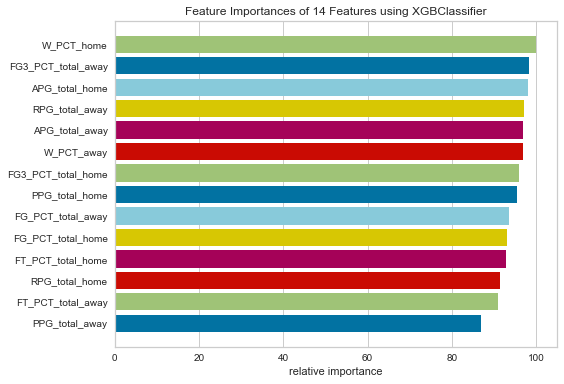

---------------------------------------------
Mean accuracy: 0.5179996036498572
Max accuracy: 0.5212378640776699
Min accuracy: 0.5109223300970874


In [27]:
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {})

## Try prune max depth

i=0
WINNER:

Best XGBoost accuracy ({'max_depth': 27}): 0.60
              precision    recall  f1-score   support

           0       0.59      0.61      0.60      2695
           1       0.61      0.58      0.59      2789

    accuracy                           0.60      5484
   macro avg       0.60      0.60      0.60      5484
weighted avg       0.60      0.60      0.60      5484



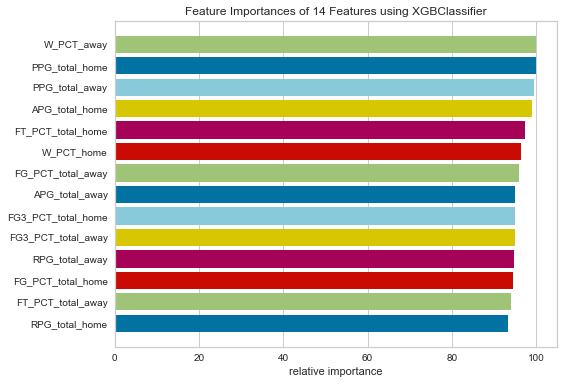

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'max_depth': 18}): 0.59
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      2780
           1       0.58      0.58      0.58      2704

    accuracy                           0.59      5484
   macro avg       0.59      0.59      0.59      5484
weighted avg       0.59      0.59      0.59      5484



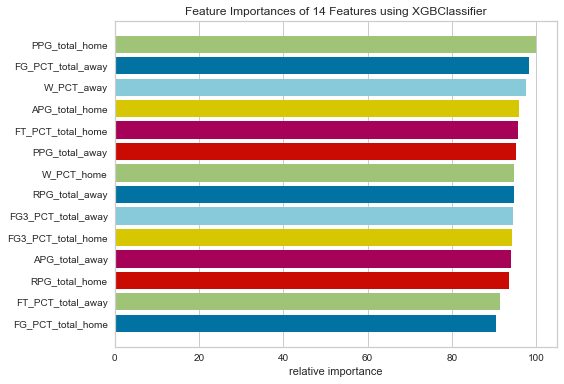

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'max_depth': 13}): 0.58
              precision    recall  f1-score   support

           0       0.57      0.59      0.58      2727
           1       0.58      0.56      0.57      2757

    accuracy                           0.58      5484
   macro avg       0.58      0.58      0.58      5484
weighted avg       0.58      0.58      0.58      5484



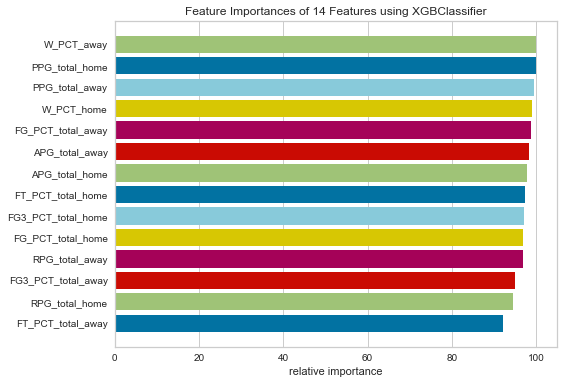

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'max_depth': 19}): 0.60
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      2715
           1       0.61      0.58      0.59      2768

    accuracy                           0.60      5483
   macro avg       0.60      0.60      0.60      5483
weighted avg       0.60      0.60      0.60      5483



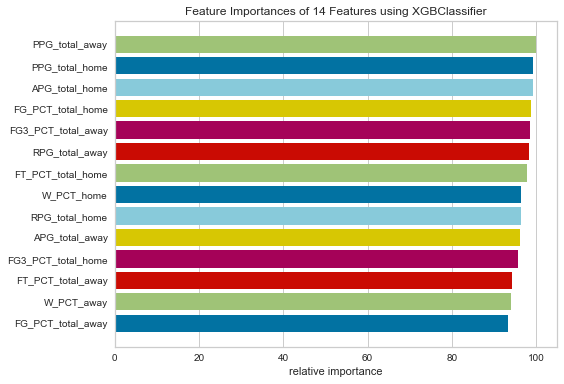

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'max_depth': 25}): 0.60
              precision    recall  f1-score   support

           0       0.60      0.61      0.60      2792
           1       0.59      0.58      0.59      2691

    accuracy                           0.60      5483
   macro avg       0.60      0.60      0.60      5483
weighted avg       0.60      0.60      0.60      5483



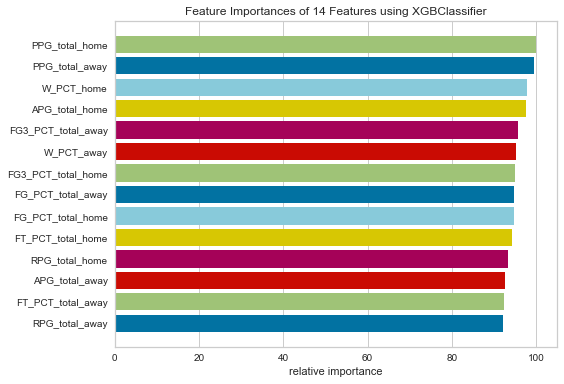

---------------------------------------------
Mean accuracy: 0.5896971865029939
Max accuracy: 0.5974831296735363
Min accuracy: 0.5773158278628738
i=5
FGP:

Best XGBoost accuracy ({'max_depth': 15}): 0.56
              precision    recall  f1-score   support

           0       0.57      0.56      0.56      2614
           1       0.55      0.55      0.55      2495

    accuracy                           0.56      5109
   macro avg       0.56      0.56      0.56      5109
weighted avg       0.56      0.56      0.56      5109



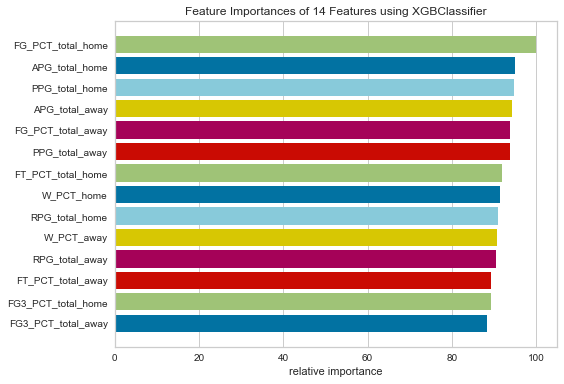

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'max_depth': 21}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      2571
           1       0.55      0.55      0.55      2538

    accuracy                           0.55      5109
   macro avg       0.55      0.55      0.55      5109
weighted avg       0.55      0.55      0.55      5109



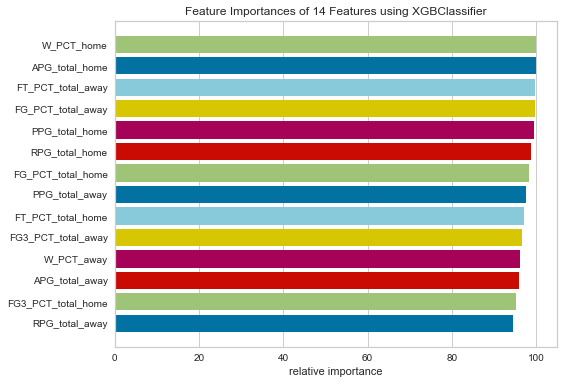

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'max_depth': 19}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      2559
           1       0.54      0.55      0.54      2549

    accuracy                           0.54      5108
   macro avg       0.54      0.54      0.54      5108
weighted avg       0.54      0.54      0.54      5108



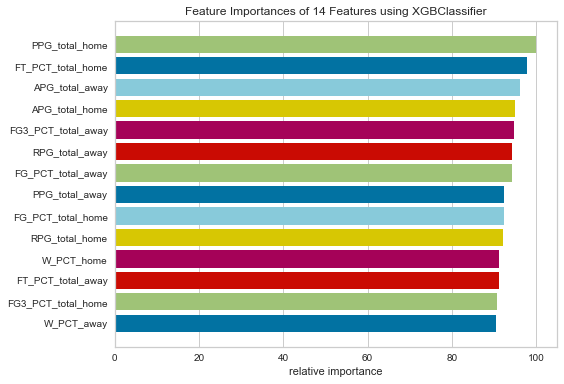

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'max_depth': 22}): 0.55
              precision    recall  f1-score   support

           0       0.54      0.57      0.55      2470
           1       0.57      0.54      0.56      2638

    accuracy                           0.55      5108
   macro avg       0.56      0.56      0.55      5108
weighted avg       0.56      0.55      0.55      5108



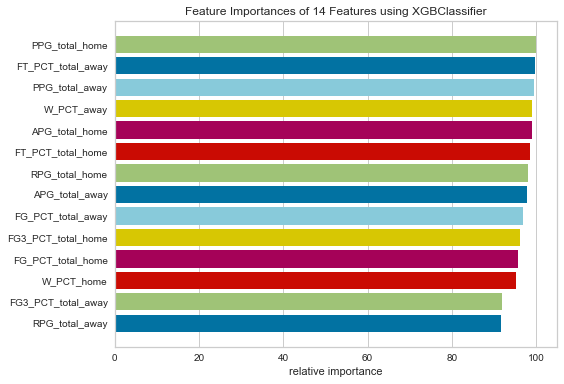

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'max_depth': 25}): 0.56
              precision    recall  f1-score   support

           0       0.56      0.56      0.56      2557
           1       0.56      0.56      0.56      2551

    accuracy                           0.56      5108
   macro avg       0.56      0.56      0.56      5108
weighted avg       0.56      0.56      0.56      5108



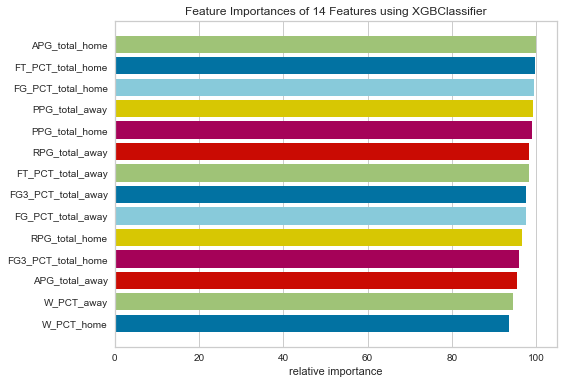

---------------------------------------------
Mean accuracy: 0.5507974511177091
Max accuracy: 0.5576433744372675
Min accuracy: 0.5418950665622553
i=10
FG3:

Best XGBoost accuracy ({'max_depth': 23}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2365
           1       0.50      0.52      0.51      2346

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



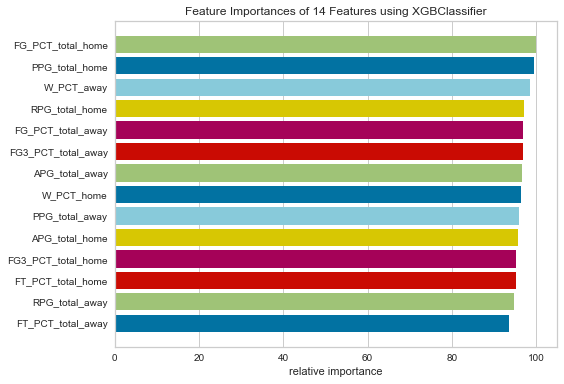

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'max_depth': 8}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2402
           1       0.49      0.50      0.49      2309

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



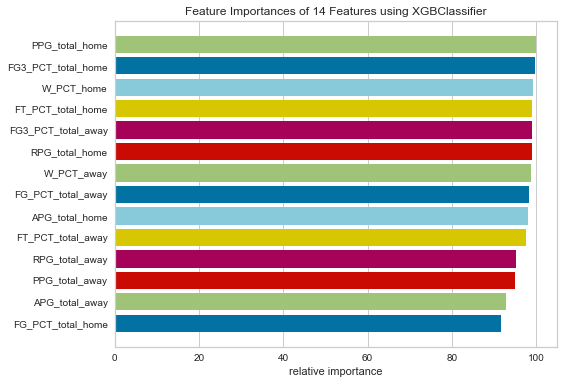

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'max_depth': 28}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.53      0.51      2284
           1       0.53      0.50      0.51      2427

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



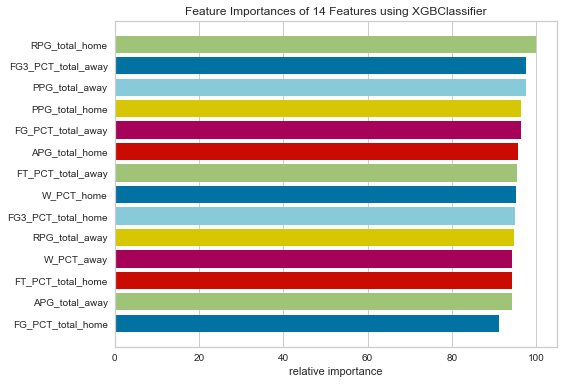

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'max_depth': 28}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.52      0.51      2307
           1       0.51      0.49      0.50      2404

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



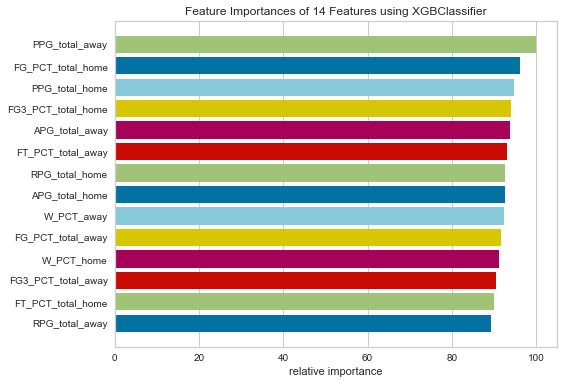

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'max_depth': 15}): 0.50
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2419
           1       0.49      0.50      0.49      2291

    accuracy                           0.50      4710
   macro avg       0.50      0.50      0.50      4710
weighted avg       0.50      0.50      0.50      4710



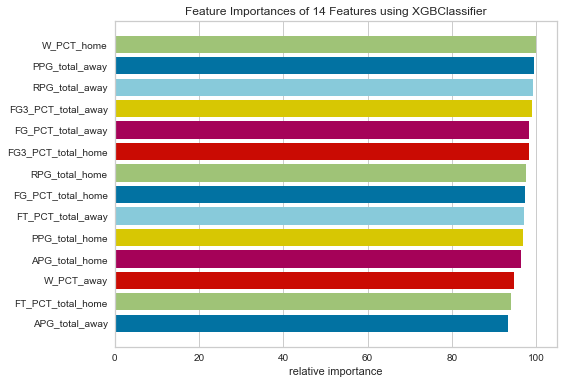

---------------------------------------------
Mean accuracy: 0.504988325196349
Max accuracy: 0.5130545531734239
Min accuracy: 0.4958607514328168
i=15
FT:

Best XGBoost accuracy ({'max_depth': 13}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2337
           1       0.51      0.54      0.52      2345

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



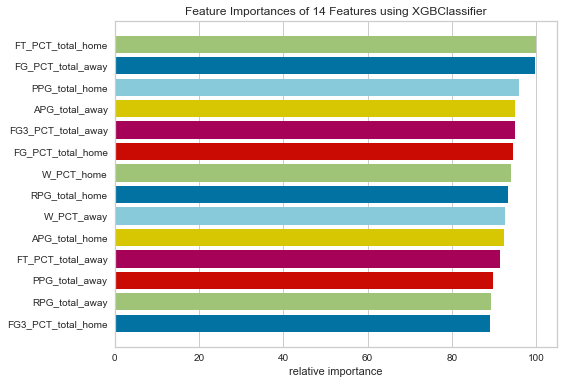

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'max_depth': 6}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2322
           1       0.51      0.51      0.51      2360

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



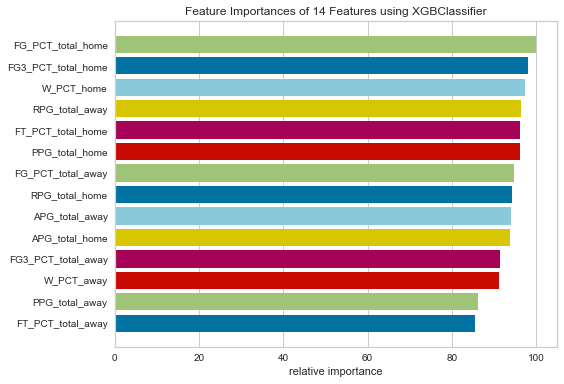

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'max_depth': 4}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2360
           1       0.50      0.50      0.50      2322

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



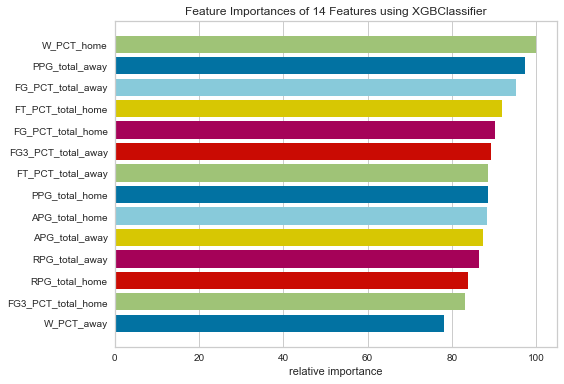

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'max_depth': 18}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.53      0.53      2343
           1       0.52      0.52      0.52      2339

    accuracy                           0.52      4682
   macro avg       0.52      0.52      0.52      4682
weighted avg       0.52      0.52      0.52      4682



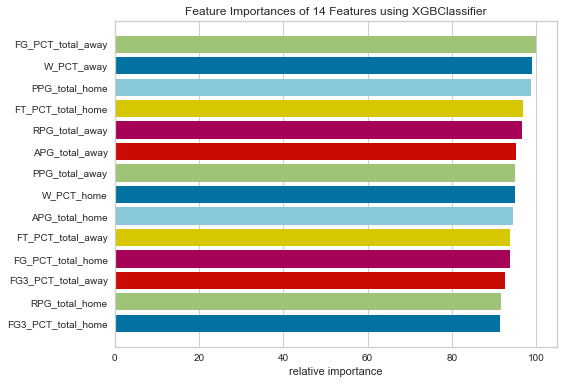

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'max_depth': 13}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.52      0.51      2343
           1       0.51      0.50      0.51      2339

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



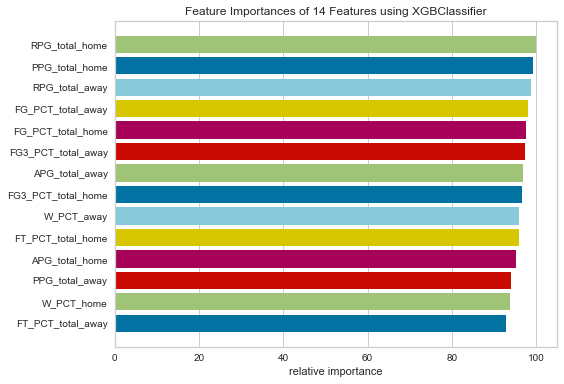

---------------------------------------------
Mean accuracy: 0.5115335326783426
Max accuracy: 0.5230670653566851
Min accuracy: 0.5040580948312687
i=20
AST:

Best XGBoost accuracy ({'max_depth': 21}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.56      0.55      2556
           1       0.55      0.55      0.55      2540

    accuracy                           0.55      5096
   macro avg       0.55      0.55      0.55      5096
weighted avg       0.55      0.55      0.55      5096



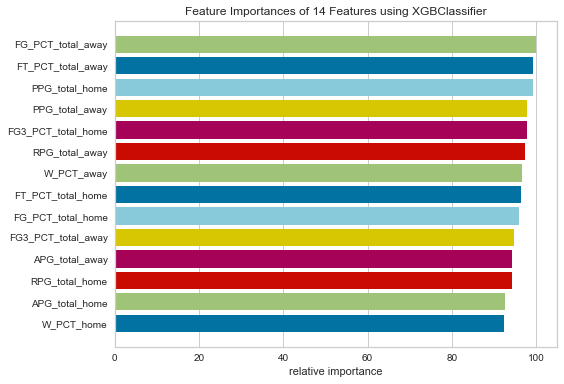

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'max_depth': 17}): 0.54
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      2578
           1       0.54      0.53      0.53      2517

    accuracy                           0.54      5095
   macro avg       0.54      0.54      0.54      5095
weighted avg       0.54      0.54      0.54      5095



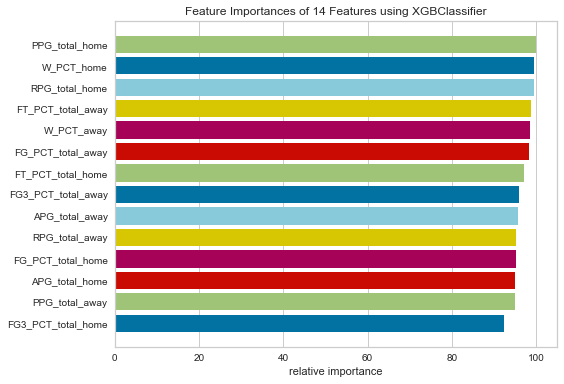

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'max_depth': 16}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2522
           1       0.56      0.54      0.55      2573

    accuracy                           0.55      5095
   macro avg       0.55      0.55      0.55      5095
weighted avg       0.55      0.55      0.55      5095



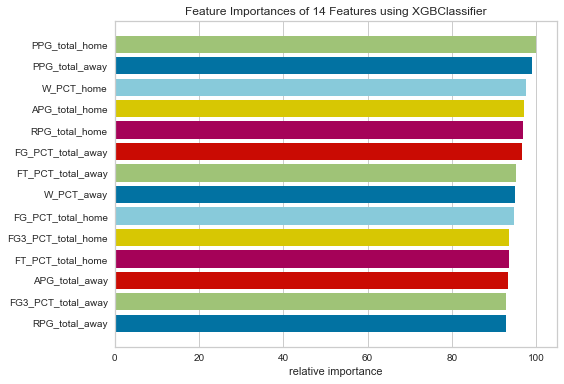

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'max_depth': 27}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      2531
           1       0.55      0.54      0.55      2564

    accuracy                           0.54      5095
   macro avg       0.54      0.54      0.54      5095
weighted avg       0.54      0.54      0.54      5095



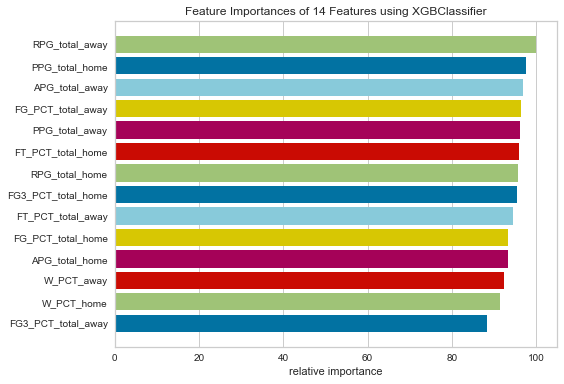

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'max_depth': 20}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.56      0.55      2551
           1       0.55      0.54      0.55      2544

    accuracy                           0.55      5095
   macro avg       0.55      0.55      0.55      5095
weighted avg       0.55      0.55      0.55      5095



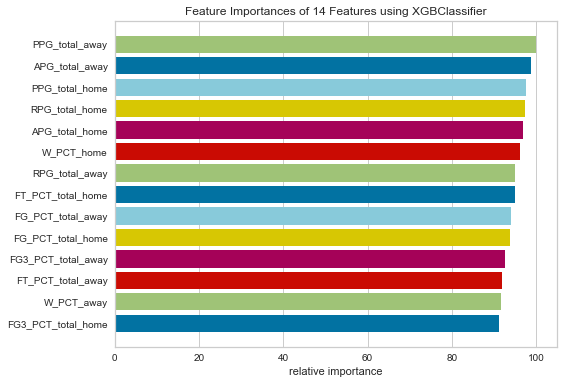

---------------------------------------------
Mean accuracy: 0.5478139158962445
Max accuracy: 0.5530912659470069
Min accuracy: 0.5413150147203141
i=25
REB:

Best XGBoost accuracy ({'max_depth': 16}): 0.53
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      2470
           1       0.53      0.51      0.52      2475

    accuracy                           0.53      4945
   macro avg       0.53      0.53      0.53      4945
weighted avg       0.53      0.53      0.53      4945



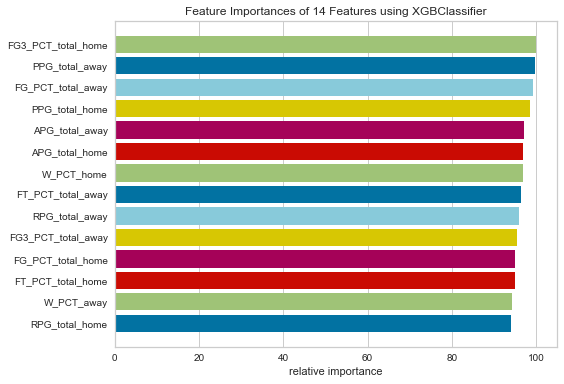

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'max_depth': 23}): 0.53
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      2413
           1       0.54      0.52      0.53      2532

    accuracy                           0.53      4945
   macro avg       0.53      0.53      0.53      4945
weighted avg       0.53      0.53      0.53      4945



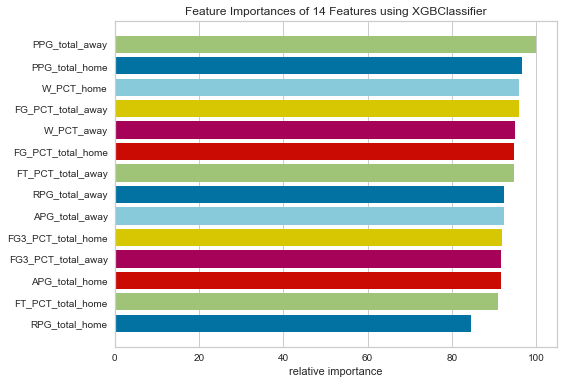

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'max_depth': 17}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      2479
           1       0.52      0.50      0.51      2465

    accuracy                           0.52      4944
   macro avg       0.52      0.52      0.52      4944
weighted avg       0.52      0.52      0.52      4944



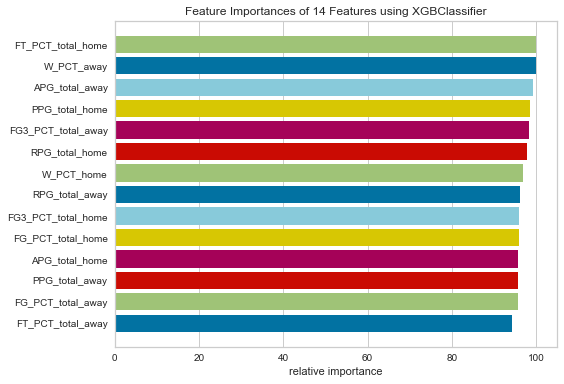

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'max_depth': 22}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.53      0.53      2473
           1       0.53      0.54      0.54      2471

    accuracy                           0.54      4944
   macro avg       0.54      0.54      0.54      4944
weighted avg       0.54      0.54      0.54      4944



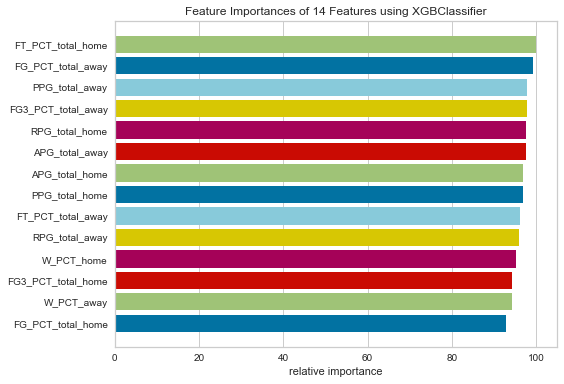

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'max_depth': 25}): 0.53
              precision    recall  f1-score   support

           0       0.55      0.52      0.53      2526
           1       0.52      0.55      0.54      2418

    accuracy                           0.53      4944
   macro avg       0.54      0.53      0.53      4944
weighted avg       0.54      0.53      0.53      4944



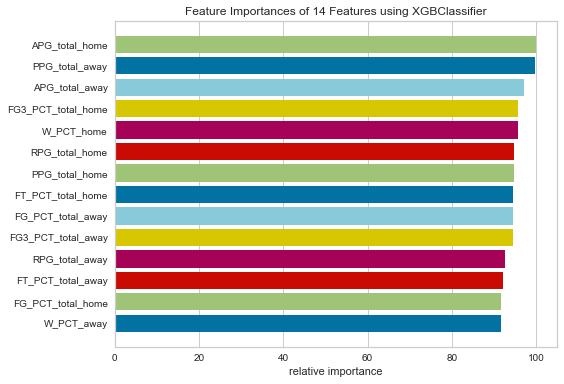

---------------------------------------------
Mean accuracy: 0.5274548962536117
Max accuracy: 0.5355987055016181
Min accuracy: 0.5222491909385113


In [25]:
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'max_depth': [*range(3,30)],
})

## Try prune reg_lambda

i=0
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.55}): 0.56
              precision    recall  f1-score   support

           0       0.54      0.59      0.57      2695
           1       0.57      0.52      0.55      2789

    accuracy                           0.56      5484
   macro avg       0.56      0.56      0.56      5484
weighted avg       0.56      0.56      0.56      5484



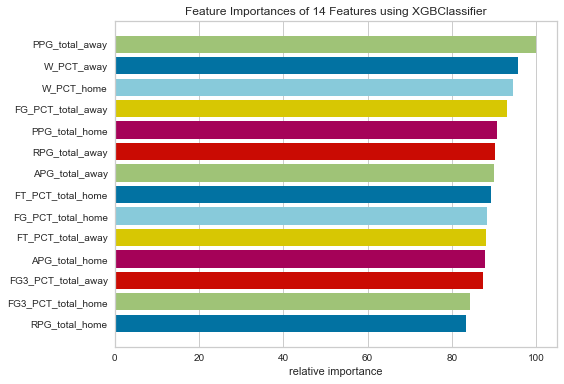

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.1}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2780
           1       0.55      0.53      0.54      2704

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



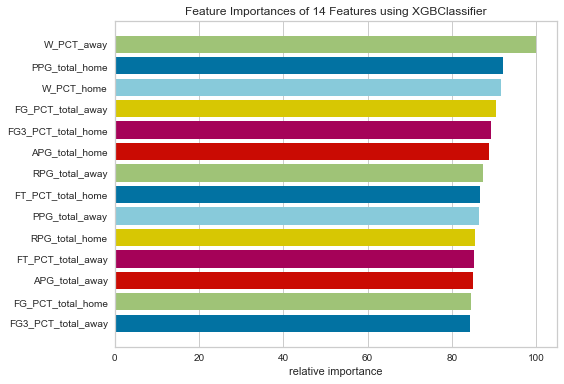

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.2}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2727
           1       0.56      0.54      0.55      2757

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



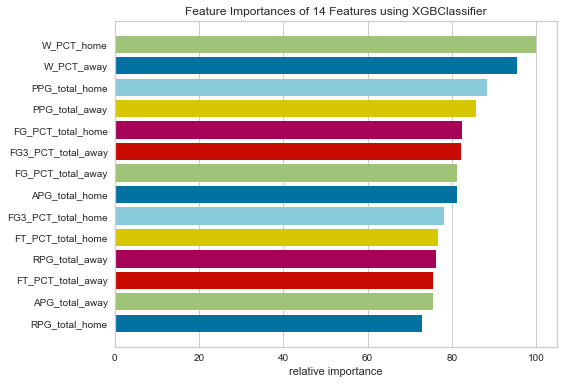

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.2}): 0.55
              precision    recall  f1-score   support

           0       0.54      0.58      0.56      2715
           1       0.56      0.52      0.54      2768

    accuracy                           0.55      5483
   macro avg       0.55      0.55      0.55      5483
weighted avg       0.55      0.55      0.55      5483



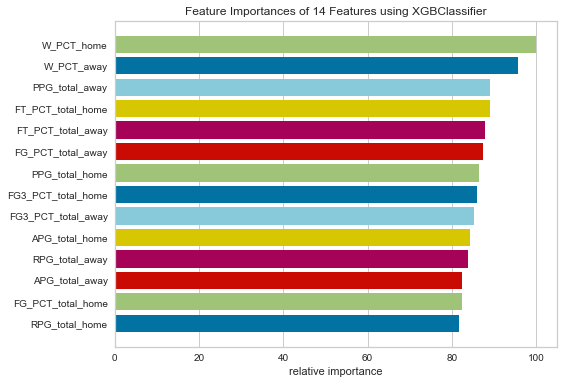

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.15}): 0.56
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      2792
           1       0.55      0.55      0.55      2691

    accuracy                           0.56      5483
   macro avg       0.56      0.56      0.56      5483
weighted avg       0.56      0.56      0.56      5483



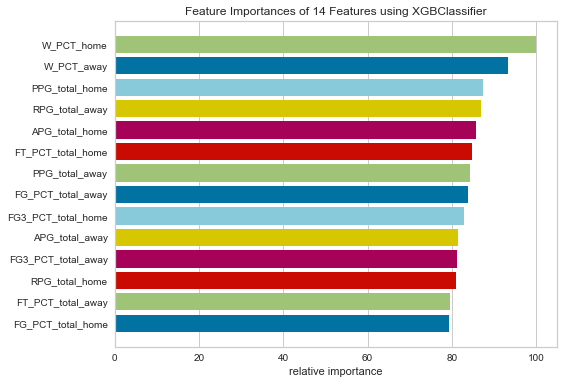

---------------------------------------------
Mean accuracy: 0.5529518132632752
Max accuracy: 0.5556163384390955
Min accuracy: 0.5505105762217359
i=5
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.15}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2614
           1       0.51      0.52      0.51      2495

    accuracy                           0.52      5109
   macro avg       0.52      0.52      0.52      5109
weighted avg       0.52      0.52      0.52      5109



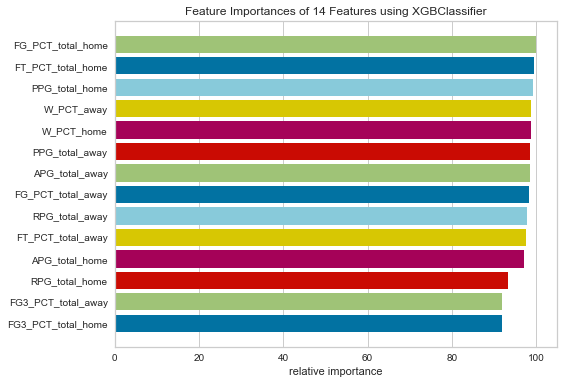

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.05}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.54      0.53      2571
           1       0.52      0.51      0.52      2538

    accuracy                           0.53      5109
   macro avg       0.53      0.53      0.53      5109
weighted avg       0.53      0.53      0.53      5109



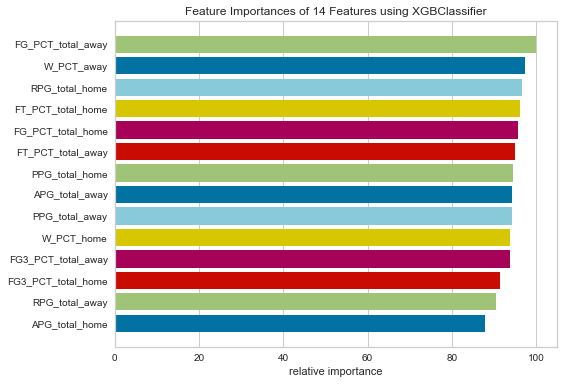

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.45}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      2559
           1       0.52      0.51      0.52      2549

    accuracy                           0.52      5108
   macro avg       0.52      0.52      0.52      5108
weighted avg       0.52      0.52      0.52      5108



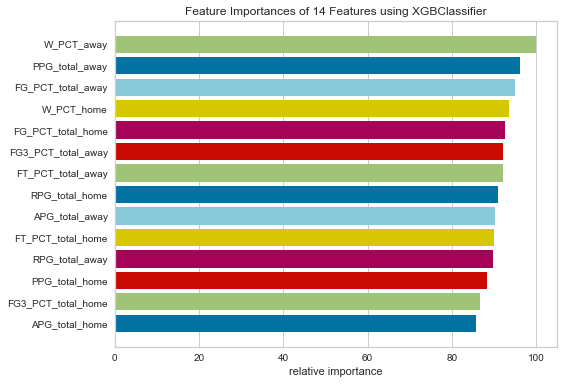

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.65}): 0.52
              precision    recall  f1-score   support

           0       0.51      0.56      0.53      2470
           1       0.54      0.49      0.52      2638

    accuracy                           0.52      5108
   macro avg       0.52      0.52      0.52      5108
weighted avg       0.52      0.52      0.52      5108



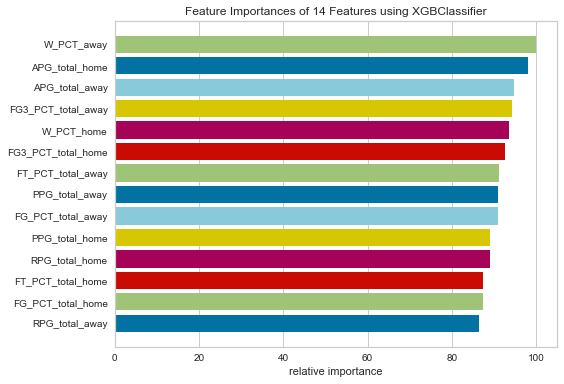

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.0}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.54      0.53      2557
           1       0.53      0.52      0.53      2551

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



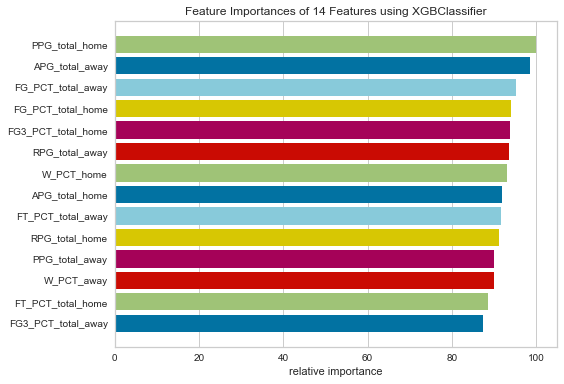

---------------------------------------------
Mean accuracy: 0.5242732223740162
Max accuracy: 0.5259346251712664
Min accuracy: 0.5232967893500392
i=10
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.9}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      2365
           1       0.51      0.51      0.51      2346

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



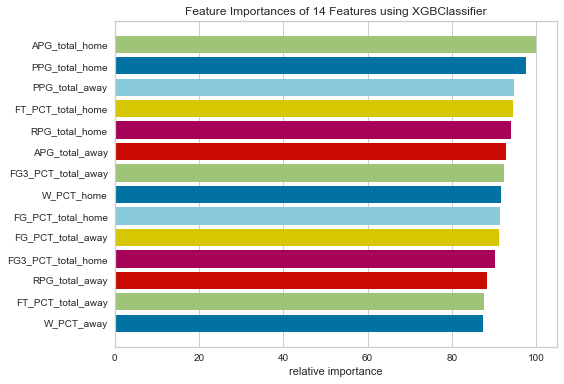

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.7}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2402
           1       0.49      0.50      0.50      2309

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



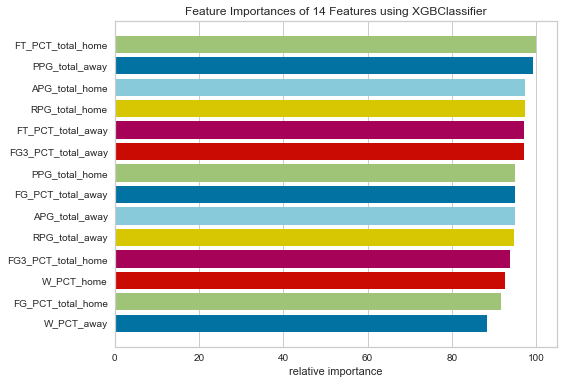

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.45}): 0.49
              precision    recall  f1-score   support

           0       0.48      0.51      0.49      2284
           1       0.51      0.48      0.49      2427

    accuracy                           0.49      4711
   macro avg       0.49      0.49      0.49      4711
weighted avg       0.49      0.49      0.49      4711



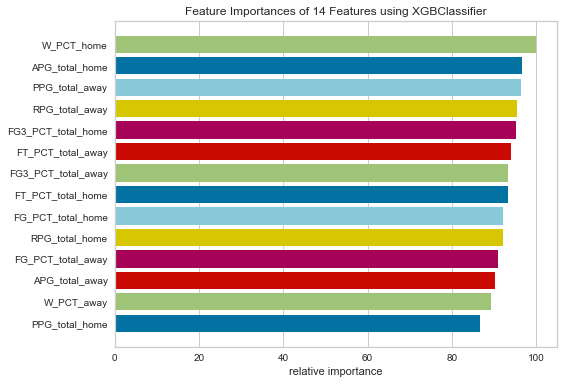

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.65}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2307
           1       0.51      0.49      0.50      2404

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



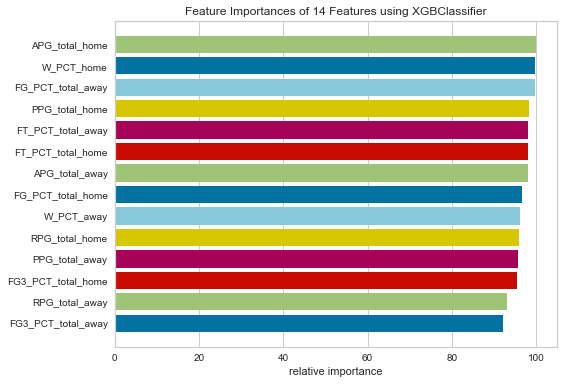

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.15}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      2419
           1       0.50      0.52      0.51      2291

    accuracy                           0.52      4710
   macro avg       0.52      0.52      0.52      4710
weighted avg       0.52      0.52      0.52      4710



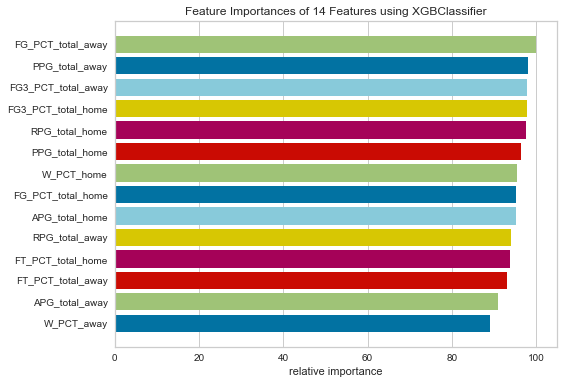

---------------------------------------------
Mean accuracy: 0.5020165569942687
Max accuracy: 0.508809170027595
Min accuracy: 0.4933135215453195
i=15
FT:

Best XGBoost accuracy ({'reg_lambda': 0.95}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      2337
           1       0.51      0.52      0.51      2345

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



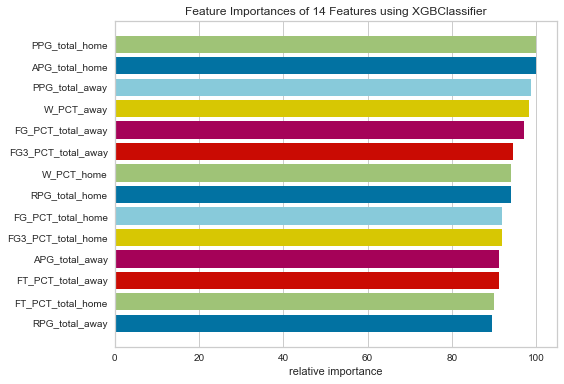

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'reg_lambda': 0.5}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      2322
           1       0.51      0.50      0.50      2360

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



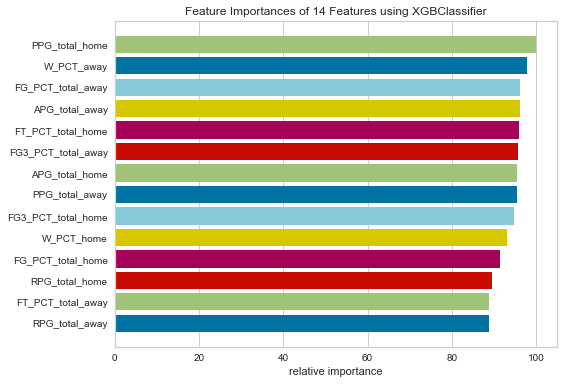

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'reg_lambda': 0.15}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2360
           1       0.50      0.50      0.50      2322

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



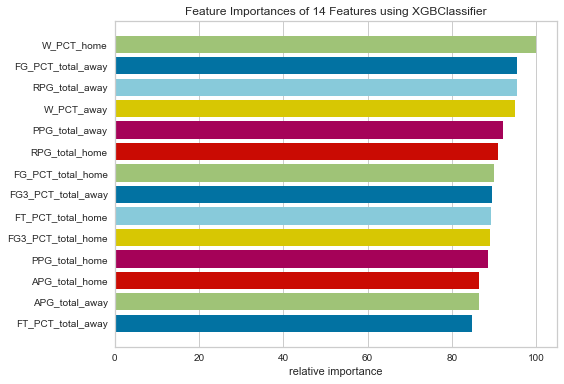

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'reg_lambda': 0.15}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2343
           1       0.50      0.50      0.50      2339

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



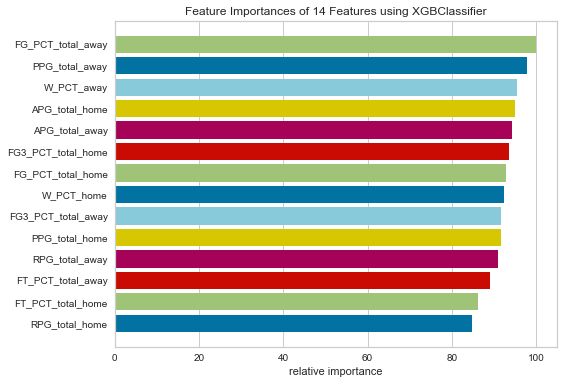

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'reg_lambda': 0.3}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2343
           1       0.50      0.50      0.50      2339

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



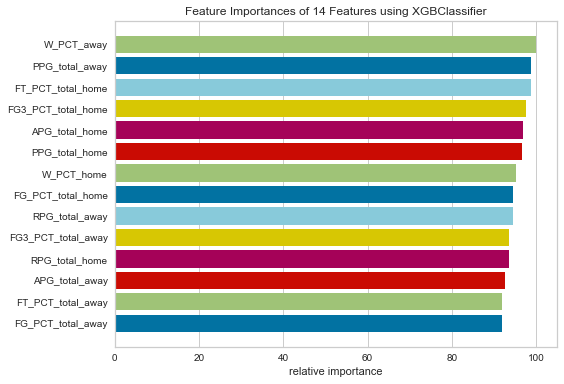

---------------------------------------------
Mean accuracy: 0.5058201623237932
Max accuracy: 0.5096112772319522
Min accuracy: 0.5019222554463905
i=20
AST:

Best XGBoost accuracy ({'reg_lambda': 0.8}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.55      0.54      2556
           1       0.52      0.49      0.51      2540

    accuracy                           0.52      5096
   macro avg       0.52      0.52      0.52      5096
weighted avg       0.52      0.52      0.52      5096



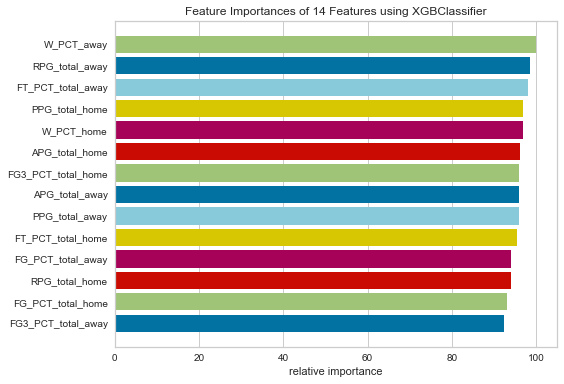

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'reg_lambda': 0.25}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2578
           1       0.51      0.50      0.50      2517

    accuracy                           0.51      5095
   macro avg       0.51      0.51      0.51      5095
weighted avg       0.51      0.51      0.51      5095



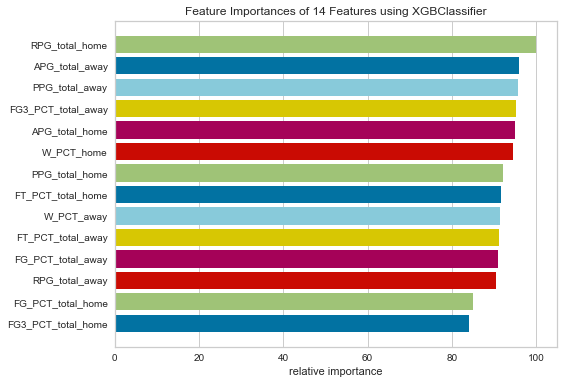

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'reg_lambda': 0.3}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      2522
           1       0.53      0.50      0.51      2573

    accuracy                           0.52      5095
   macro avg       0.52      0.52      0.52      5095
weighted avg       0.52      0.52      0.52      5095



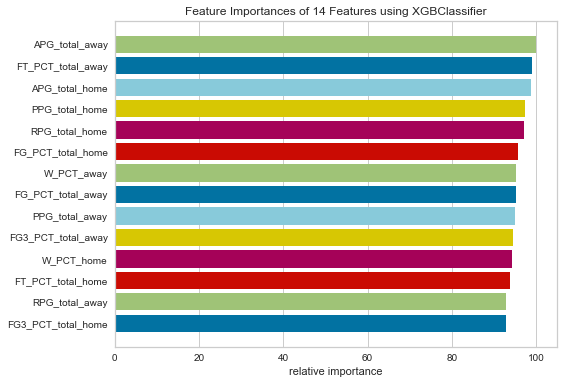

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'reg_lambda': 1}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      2531
           1       0.52      0.50      0.51      2564

    accuracy                           0.52      5095
   macro avg       0.52      0.52      0.52      5095
weighted avg       0.52      0.52      0.52      5095



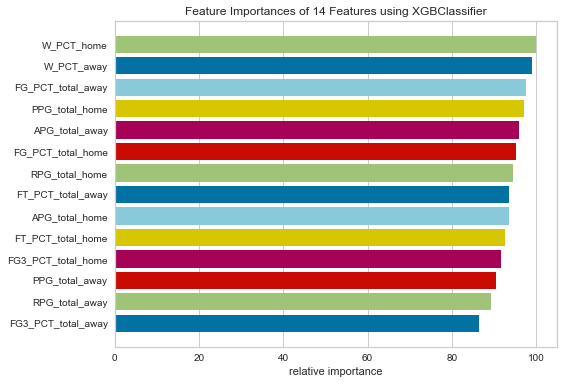

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'reg_lambda': 0.35}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2551
           1       0.53      0.50      0.52      2544

    accuracy                           0.53      5095
   macro avg       0.53      0.53      0.53      5095
weighted avg       0.53      0.53      0.53      5095



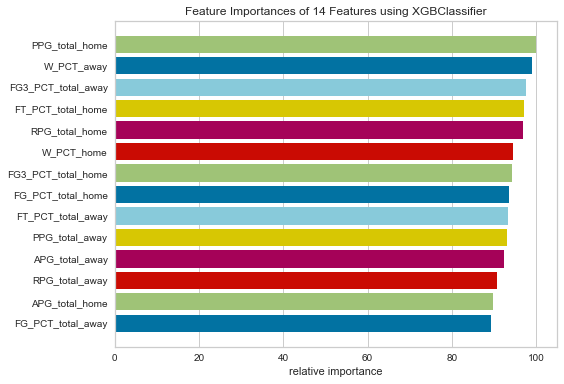

---------------------------------------------
Mean accuracy: 0.519159825174125
Max accuracy: 0.5227629513343799
Min accuracy: 0.512855740922473
i=25
REB:

Best XGBoost accuracy ({'reg_lambda': 0.85}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.52      0.51      2470
           1       0.51      0.49      0.50      2475

    accuracy                           0.51      4945
   macro avg       0.51      0.51      0.51      4945
weighted avg       0.51      0.51      0.51      4945



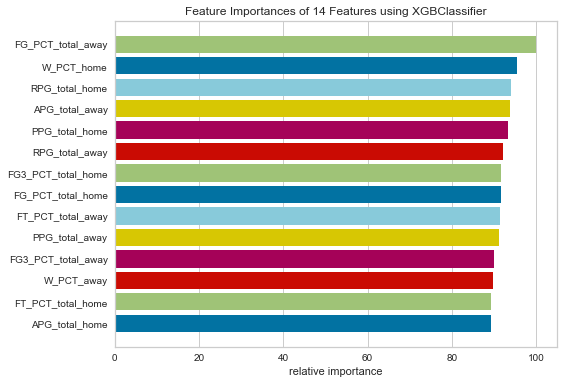

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'reg_lambda': 0.05}): 0.52
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      2413
           1       0.53      0.51      0.52      2532

    accuracy                           0.52      4945
   macro avg       0.52      0.52      0.52      4945
weighted avg       0.52      0.52      0.52      4945



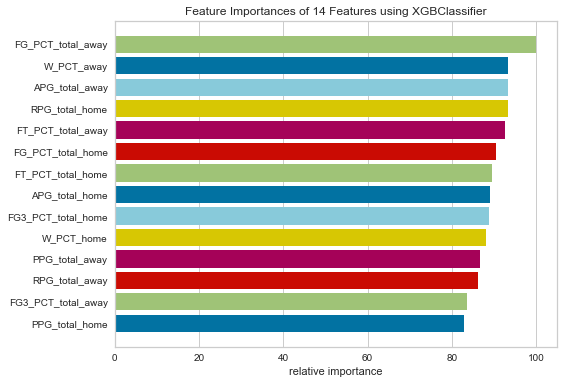

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'reg_lambda': 0.15}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2479
           1       0.51      0.51      0.51      2465

    accuracy                           0.52      4944
   macro avg       0.52      0.52      0.52      4944
weighted avg       0.52      0.52      0.52      4944



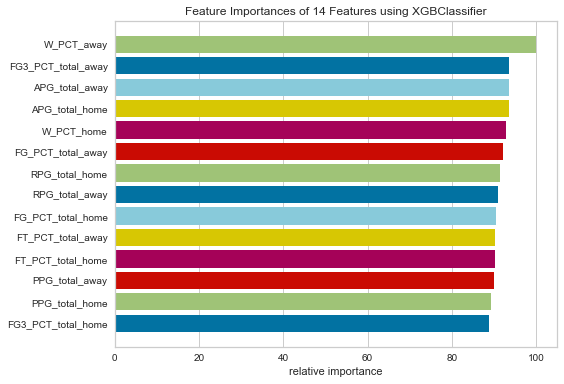

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'reg_lambda': 0.75}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2473
           1       0.51      0.51      0.51      2471

    accuracy                           0.51      4944
   macro avg       0.51      0.51      0.51      4944
weighted avg       0.51      0.51      0.51      4944



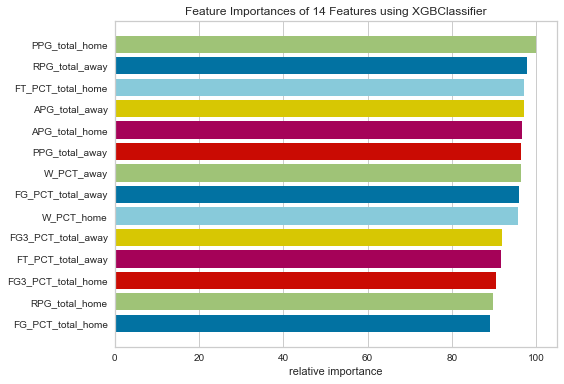

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'reg_lambda': 0.15}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2526
           1       0.49      0.50      0.50      2418

    accuracy                           0.50      4944
   macro avg       0.50      0.50      0.50      4944
weighted avg       0.50      0.50      0.50      4944



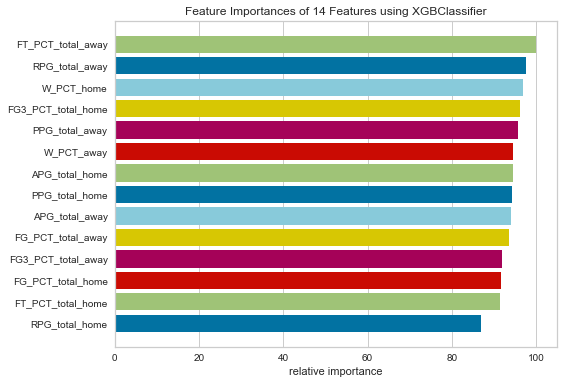

---------------------------------------------
Mean accuracy: 0.5129942923943313
Max accuracy: 0.5183013144590496
Min accuracy: 0.506572295247725


In [26]:
# L2 regularization term on weights. Increasing this value will make model more conservative.

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'reg_lambda': [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
})

## Try prune learning rate

i=0
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.95}): 0.55
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      2695
           1       0.56      0.53      0.54      2789

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



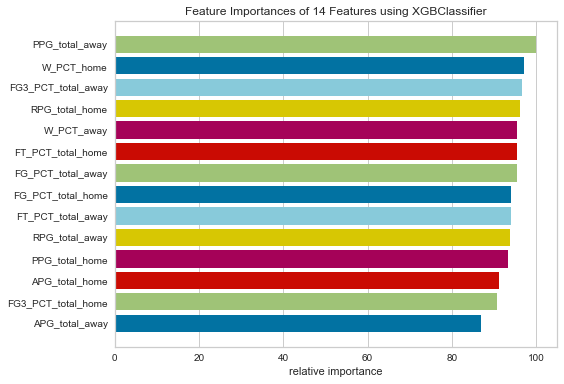

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.51
              precision    recall  f1-score   support

           0       0.51      1.00      0.67      2780
           1       0.00      0.00      0.00      2704

    accuracy                           0.51      5484
   macro avg       0.25      0.50      0.34      5484
weighted avg       0.26      0.51      0.34      5484



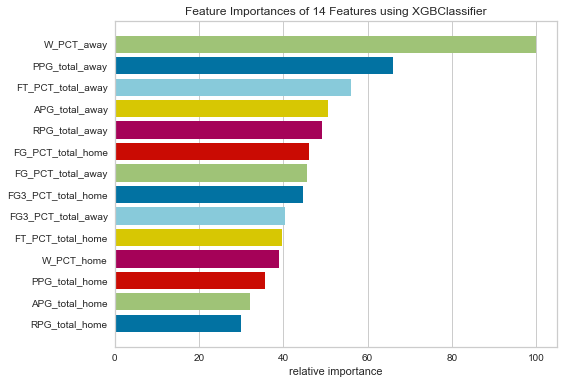

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.85}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.56      0.55      2727
           1       0.55      0.54      0.55      2757

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



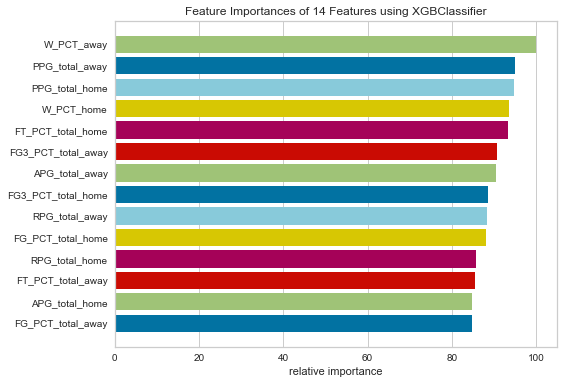

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.9}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2715
           1       0.56      0.53      0.55      2768

    accuracy                           0.55      5483
   macro avg       0.55      0.55      0.55      5483
weighted avg       0.55      0.55      0.55      5483



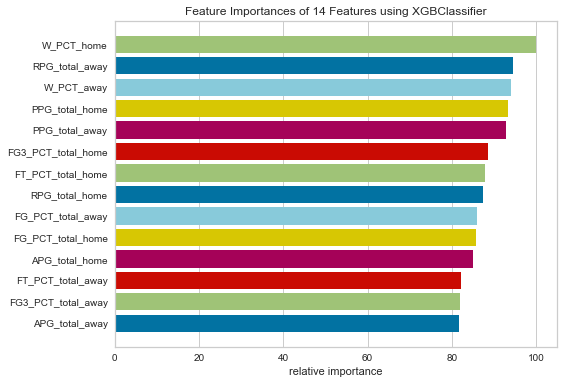

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.51
              precision    recall  f1-score   support

           0       0.51      1.00      0.67      2792
           1       0.00      0.00      0.00      2691

    accuracy                           0.51      5483
   macro avg       0.25      0.50      0.34      5483
weighted avg       0.26      0.51      0.34      5483



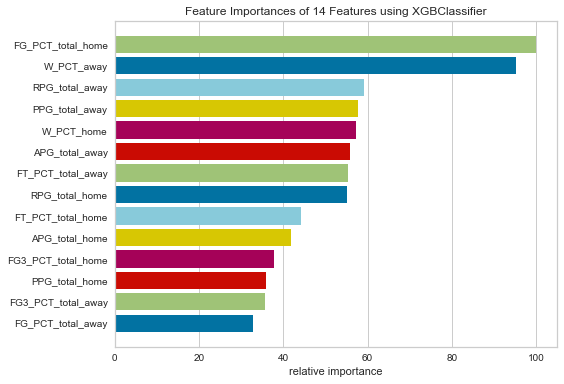

---------------------------------------------
Mean accuracy: 0.5389566042138336
Max accuracy: 0.5520700346525624
Min accuracy: 0.5069292487235595
i=5
FGP:

Best XGBoost accuracy ({'learning_rate': 0.95}): 0.53
              precision    recall  f1-score   support

           0       0.54      0.55      0.55      2614
           1       0.52      0.52      0.52      2495

    accuracy                           0.53      5109
   macro avg       0.53      0.53      0.53      5109
weighted avg       0.53      0.53      0.53      5109



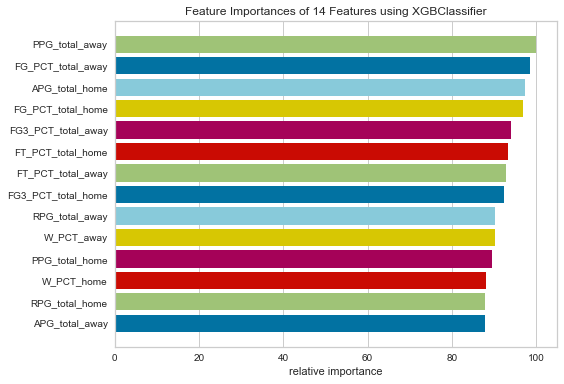

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'learning_rate': 0.9}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.52      0.52      2571
           1       0.52      0.53      0.53      2538

    accuracy                           0.53      5109
   macro avg       0.53      0.53      0.53      5109
weighted avg       0.53      0.53      0.53      5109



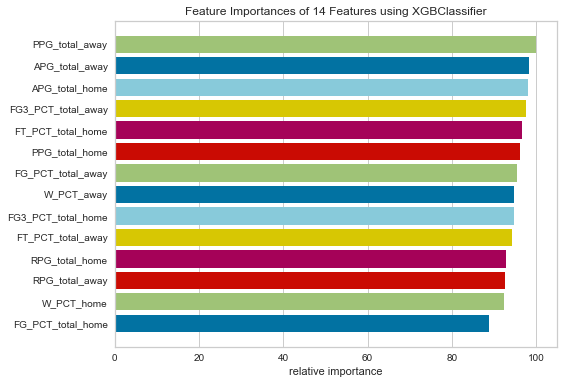

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2559
           1       0.00      0.00      0.00      2549

    accuracy                           0.50      5108
   macro avg       0.25      0.50      0.33      5108
weighted avg       0.25      0.50      0.33      5108



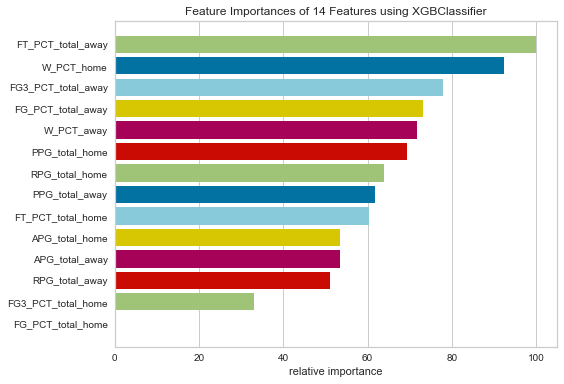

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'learning_rate': 0.9}): 0.52
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      2470
           1       0.54      0.51      0.52      2638

    accuracy                           0.52      5108
   macro avg       0.52      0.52      0.52      5108
weighted avg       0.52      0.52      0.52      5108



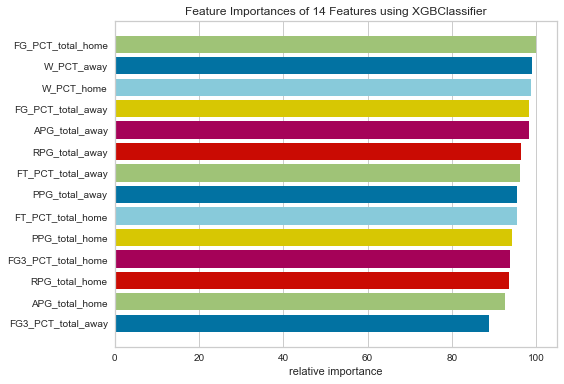

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2557
           1       0.00      0.00      0.00      2551

    accuracy                           0.50      5108
   macro avg       0.25      0.50      0.33      5108
weighted avg       0.25      0.50      0.33      5108



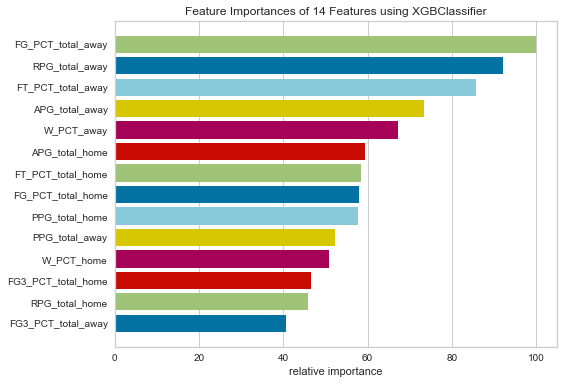

---------------------------------------------
Mean accuracy: 0.5205041355306319
Max accuracy: 0.5343511450381679
Min accuracy: 0.5009788566953798
i=10
FG3:

Best XGBoost accuracy ({'learning_rate': 0.2}): 0.48
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      2365
           1       0.48      0.49      0.49      2346

    accuracy                           0.48      4711
   macro avg       0.48      0.48      0.48      4711
weighted avg       0.48      0.48      0.48      4711



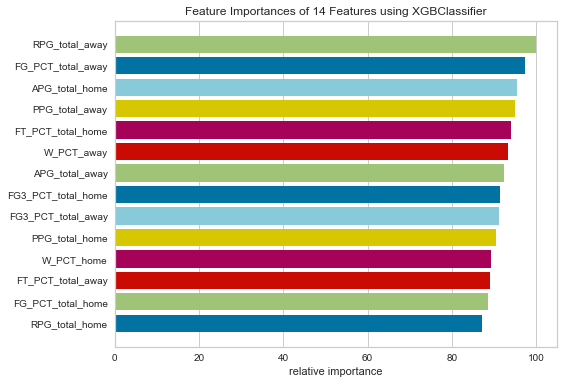

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.51
              precision    recall  f1-score   support

           0       0.51      1.00      0.68      2402
           1       0.00      0.00      0.00      2309

    accuracy                           0.51      4711
   macro avg       0.25      0.50      0.34      4711
weighted avg       0.26      0.51      0.34      4711



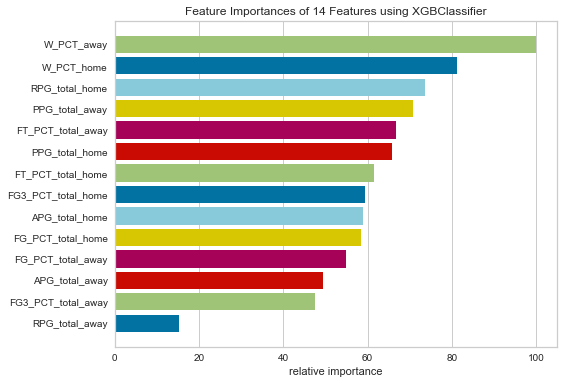

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'learning_rate': 0.7}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2284
           1       0.52      0.50      0.51      2427

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



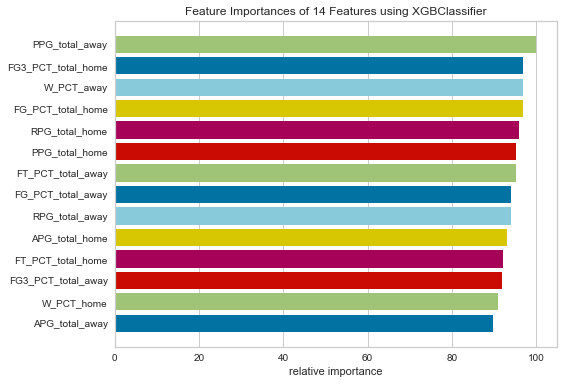

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'learning_rate': 0.3}): 0.49
              precision    recall  f1-score   support

           0       0.48      0.51      0.50      2307
           1       0.50      0.48      0.49      2404

    accuracy                           0.49      4711
   macro avg       0.49      0.49      0.49      4711
weighted avg       0.49      0.49      0.49      4711



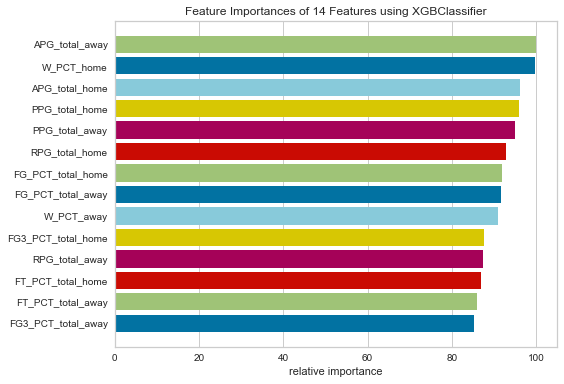

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'learning_rate': 0.15}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2419
           1       0.49      0.51      0.50      2291

    accuracy                           0.50      4710
   macro avg       0.50      0.50      0.50      4710
weighted avg       0.50      0.50      0.50      4710



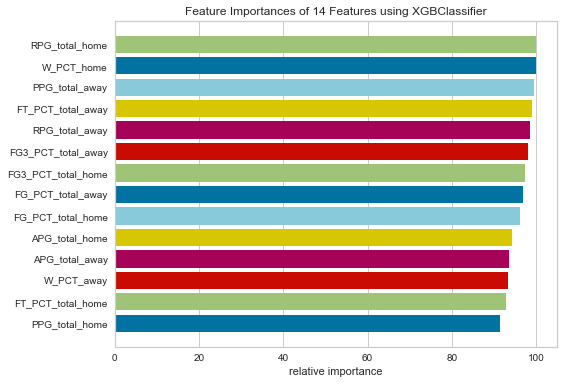

---------------------------------------------
Mean accuracy: 0.498089577584377
Max accuracy: 0.5098705158140522
Min accuracy: 0.48482275525366164
i=15
FT:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2337
           1       0.00      0.00      0.00      2345

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



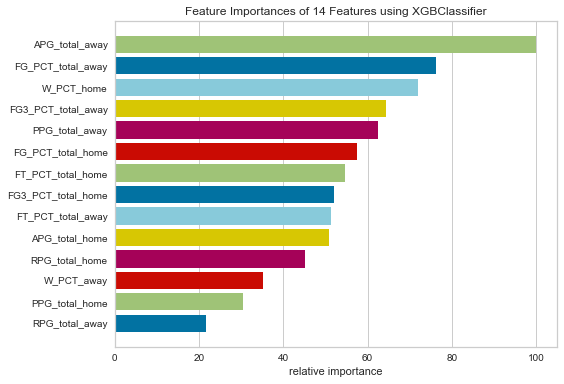

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2322
           1       0.00      0.00      0.00      2360

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



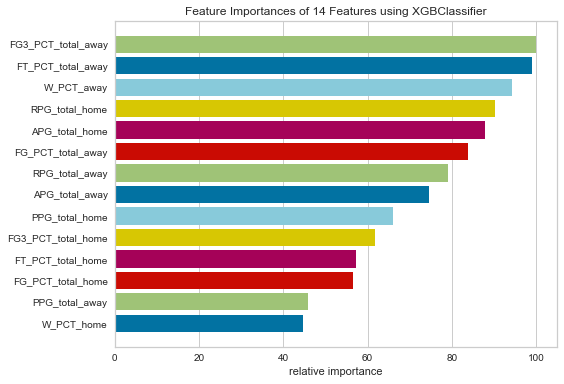

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'learning_rate': 0.85}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2360
           1       0.51      0.51      0.51      2322

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



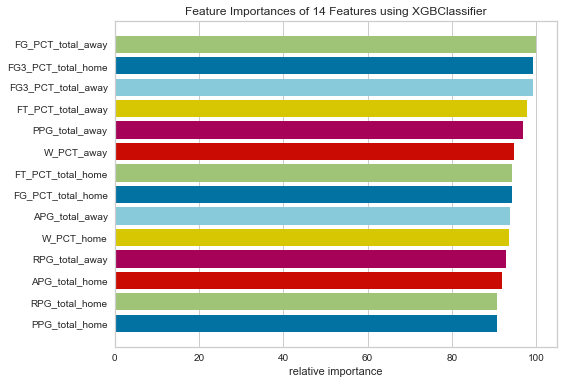

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'learning_rate': 0.85}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2343
           1       0.50      0.50      0.50      2339

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



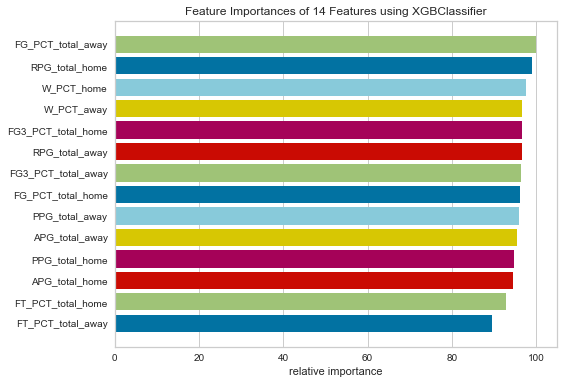

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'learning_rate': 0.75}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2343
           1       0.50      0.50      0.50      2339

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



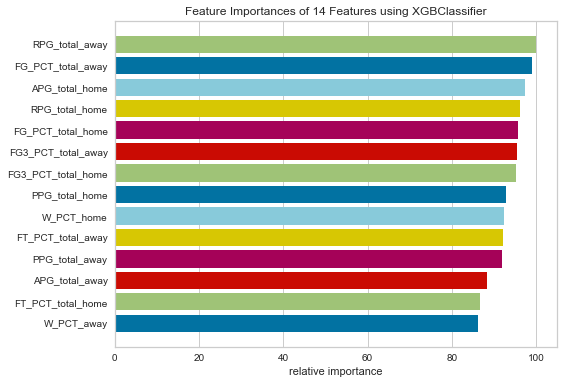

---------------------------------------------
Mean accuracy: 0.5021892353695002
Max accuracy: 0.5115335326783426
Min accuracy: 0.4959419051687313
i=20
AST:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2556
           1       0.00      0.00      0.00      2540

    accuracy                           0.50      5096
   macro avg       0.25      0.50      0.33      5096
weighted avg       0.25      0.50      0.34      5096



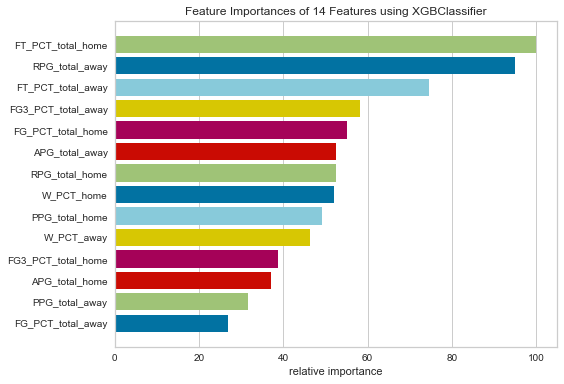

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.51
              precision    recall  f1-score   support

           0       0.51      1.00      0.67      2578
           1       0.00      0.00      0.00      2517

    accuracy                           0.51      5095
   macro avg       0.25      0.50      0.34      5095
weighted avg       0.26      0.51      0.34      5095



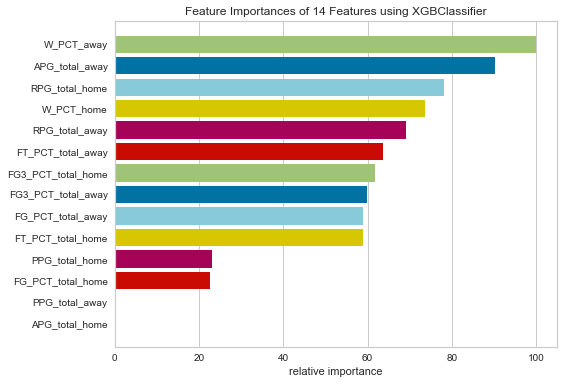

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'learning_rate': 0.85}): 0.53
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      2522
           1       0.53      0.51      0.52      2573

    accuracy                           0.53      5095
   macro avg       0.53      0.53      0.53      5095
weighted avg       0.53      0.53      0.53      5095



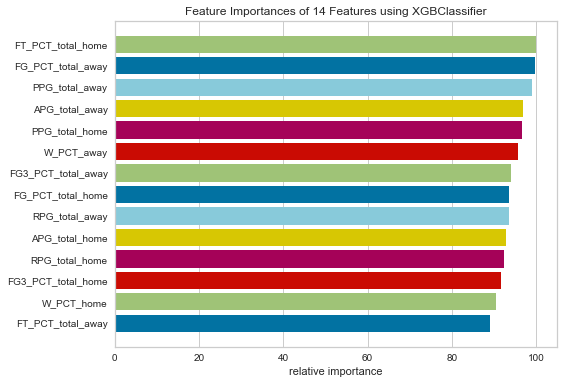

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'learning_rate': 0.9}): 0.52
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      2531
           1       0.52      0.51      0.52      2564

    accuracy                           0.52      5095
   macro avg       0.52      0.52      0.52      5095
weighted avg       0.52      0.52      0.52      5095



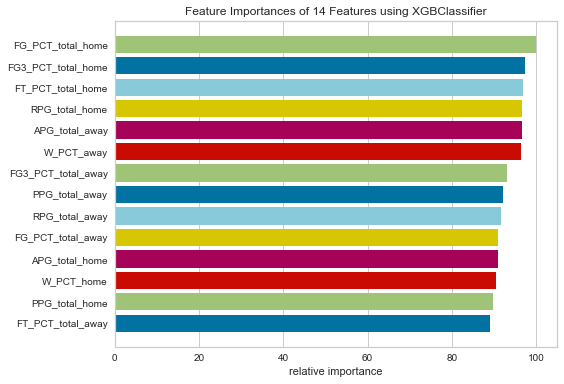

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'learning_rate': 0.9}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2551
           1       0.53      0.52      0.53      2544

    accuracy                           0.53      5095
   macro avg       0.53      0.53      0.53      5095
weighted avg       0.53      0.53      0.53      5095



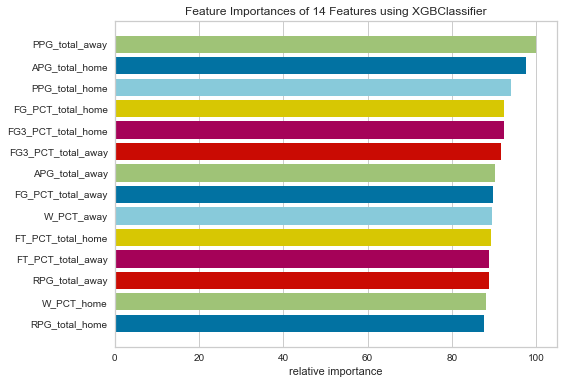

---------------------------------------------
Mean accuracy: 0.5126839268960396
Max accuracy: 0.5254170755642787
Min accuracy: 0.5015698587127159
i=25
REB:

Best XGBoost accuracy ({'learning_rate': 0.95}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.53      0.52      2470
           1       0.52      0.51      0.51      2475

    accuracy                           0.52      4945
   macro avg       0.52      0.52      0.52      4945
weighted avg       0.52      0.52      0.52      4945



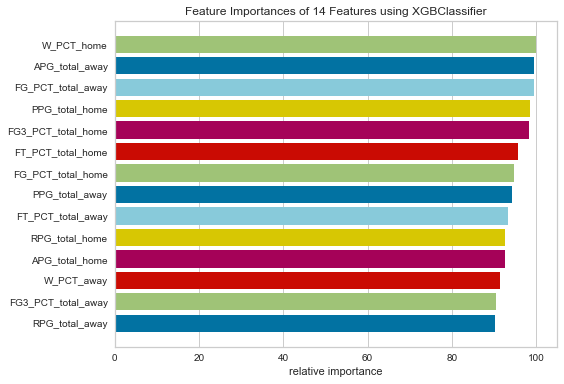

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'learning_rate': 0.9}): 0.52
              precision    recall  f1-score   support

           0       0.51      0.54      0.52      2413
           1       0.54      0.50      0.52      2532

    accuracy                           0.52      4945
   macro avg       0.52      0.52      0.52      4945
weighted avg       0.52      0.52      0.52      4945



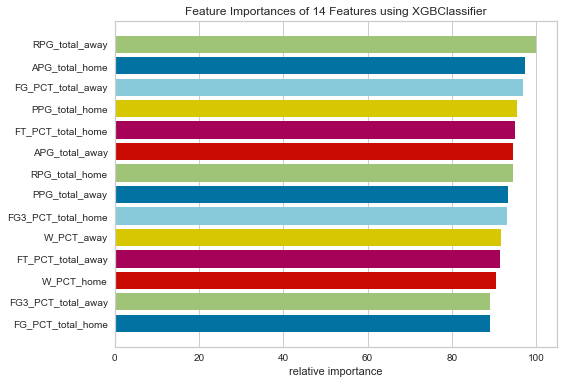

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2479
           1       0.00      0.00      0.00      2465

    accuracy                           0.50      4944
   macro avg       0.25      0.50      0.33      4944
weighted avg       0.25      0.50      0.33      4944



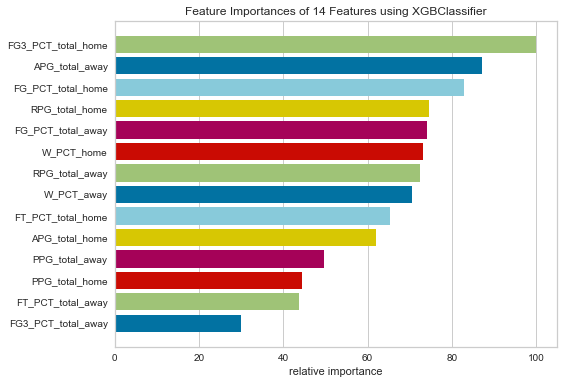

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2473
           1       0.00      0.00      0.00      2471

    accuracy                           0.50      4944
   macro avg       0.25      0.50      0.33      4944
weighted avg       0.25      0.50      0.33      4944



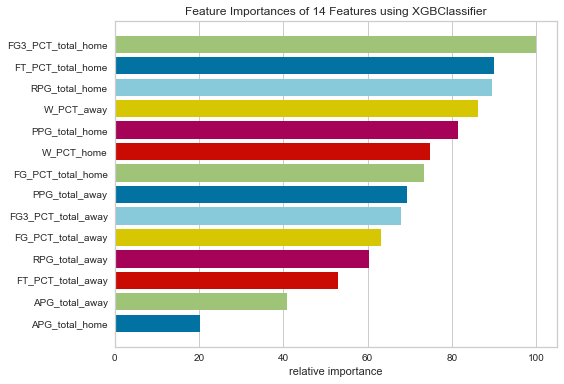

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'learning_rate': 0.65}): 0.50
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      2526
           1       0.49      0.51      0.50      2418

    accuracy                           0.50      4944
   macro avg       0.50      0.50      0.50      4944
weighted avg       0.50      0.50      0.50      4944



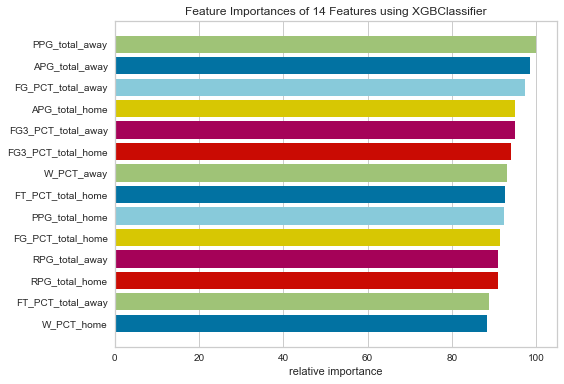

---------------------------------------------
Mean accuracy: 0.5108190909061161
Max accuracy: 0.5217391304347826
Min accuracy: 0.5002022653721683


In [27]:
# Step size shrinkage used in update to prevent overfitting.  
# After each boosting step, we can directly get the weights of new features. 
# learnig rate shrinks the feature weights to make the boosting process more conservative.

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'learning_rate' : [0.0,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
})

## Try prune gamma

i=0
WINNER:

Best XGBoost accuracy ({'gamma': 26}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.75      0.60      2695
           1       0.53      0.28      0.36      2789

    accuracy                           0.51      5484
   macro avg       0.51      0.51      0.48      5484
weighted avg       0.51      0.51      0.48      5484



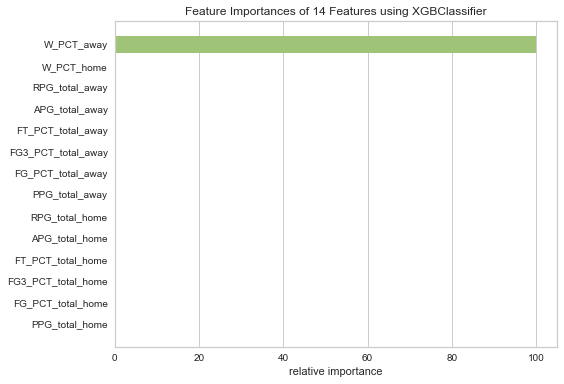

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'gamma': 29}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.78      0.62      2780
           1       0.51      0.24      0.32      2704

    accuracy                           0.51      5484
   macro avg       0.51      0.51      0.47      5484
weighted avg       0.51      0.51      0.47      5484



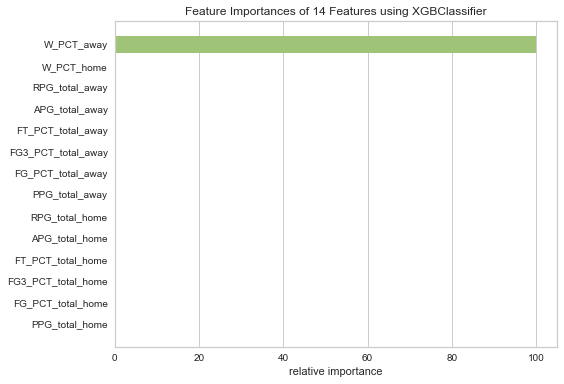

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'gamma': 28}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.78      0.61      2727
           1       0.53      0.25      0.34      2757

    accuracy                           0.51      5484
   macro avg       0.52      0.51      0.48      5484
weighted avg       0.52      0.51      0.48      5484



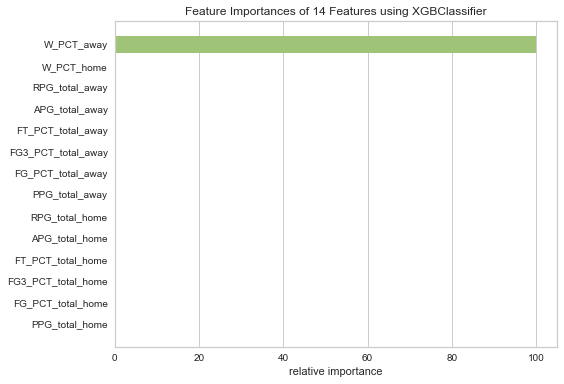

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'gamma': 1}): 0.56
              precision    recall  f1-score   support

           0       0.55      0.58      0.56      2715
           1       0.56      0.53      0.55      2768

    accuracy                           0.56      5483
   macro avg       0.56      0.56      0.56      5483
weighted avg       0.56      0.56      0.56      5483



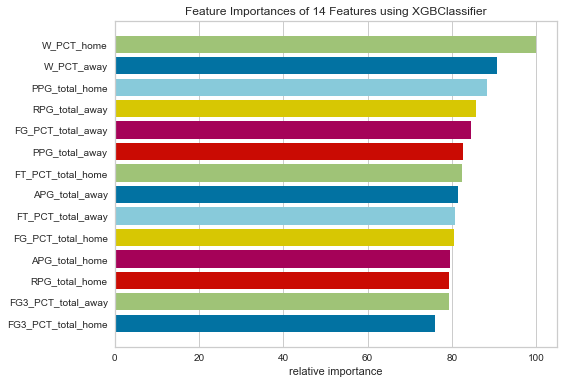

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'gamma': 24}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.31      0.39      2792
           1       0.50      0.71      0.58      2691

    accuracy                           0.51      5483
   macro avg       0.51      0.51      0.49      5483
weighted avg       0.51      0.51      0.49      5483



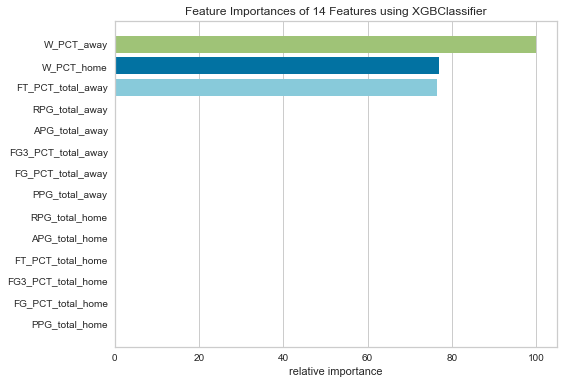

---------------------------------------------
Mean accuracy: 0.52167922753879
Max accuracy: 0.5555352908991428
Min accuracy: 0.5071115973741794
i=5
FGP:

Best XGBoost accuracy ({'gamma': 0}): 0.53
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      2614
           1       0.52      0.52      0.52      2495

    accuracy                           0.53      5109
   macro avg       0.53      0.53      0.53      5109
weighted avg       0.53      0.53      0.53      5109



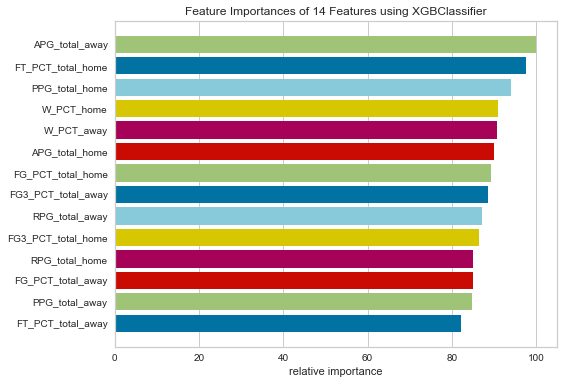

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'gamma': 2}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2571
           1       0.52      0.53      0.52      2538

    accuracy                           0.53      5109
   macro avg       0.53      0.53      0.53      5109
weighted avg       0.53      0.53      0.53      5109



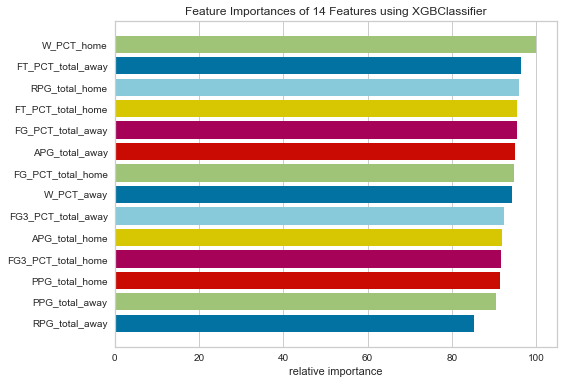

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'gamma': 1}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2559
           1       0.53      0.51      0.52      2549

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



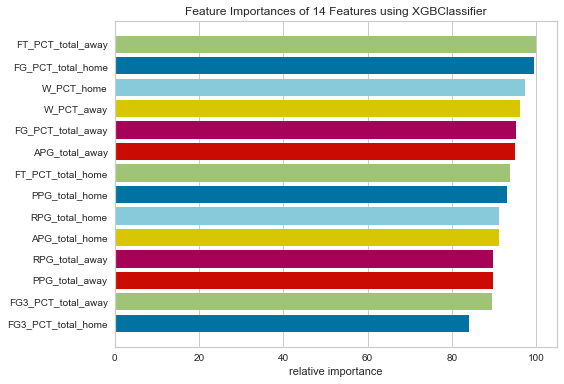

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'gamma': 25}): 0.48
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      2470
           1       0.00      0.00      0.00      2638

    accuracy                           0.48      5108
   macro avg       0.24      0.50      0.33      5108
weighted avg       0.23      0.48      0.32      5108



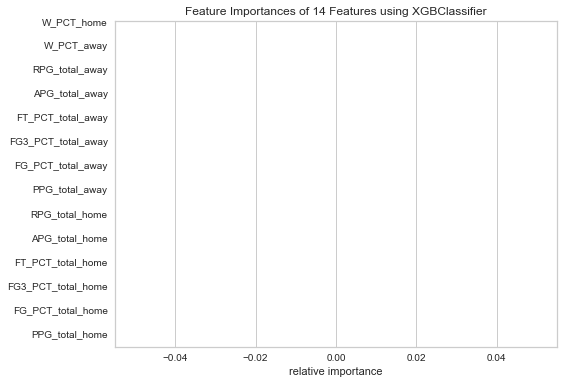

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'gamma': 1}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2557
           1       0.53      0.51      0.52      2551

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



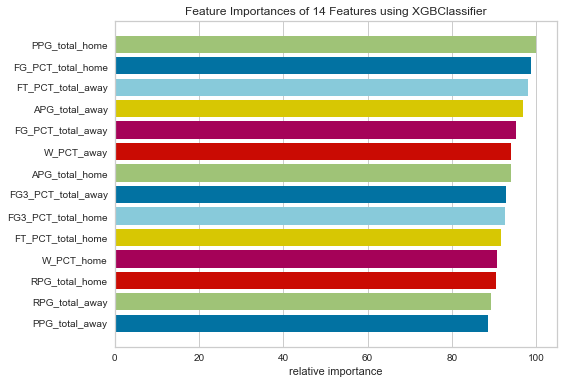

---------------------------------------------
Mean accuracy: 0.5179591272821021
Max accuracy: 0.532002348796242
Min accuracy: 0.48355520751761943
i=10
FG3:

Best XGBoost accuracy ({'gamma': 21}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2365
           1       0.50      1.00      0.66      2346

    accuracy                           0.50      4711
   macro avg       0.25      0.50      0.33      4711
weighted avg       0.25      0.50      0.33      4711



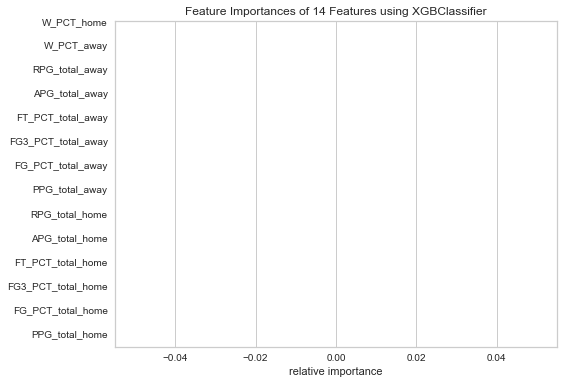

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'gamma': 17}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2402
           1       0.49      1.00      0.66      2309

    accuracy                           0.49      4711
   macro avg       0.25      0.50      0.33      4711
weighted avg       0.24      0.49      0.32      4711



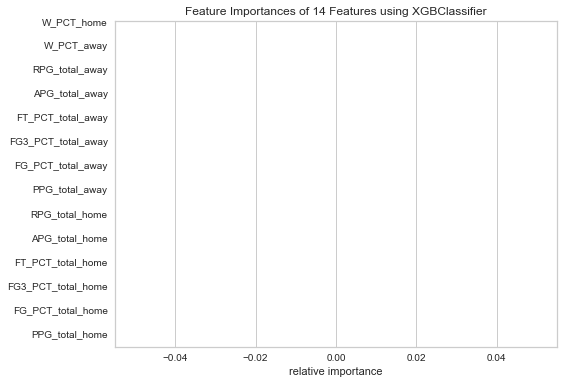

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'gamma': 21}): 0.48
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      2284
           1       0.00      0.00      0.00      2427

    accuracy                           0.48      4711
   macro avg       0.24      0.50      0.33      4711
weighted avg       0.24      0.48      0.32      4711



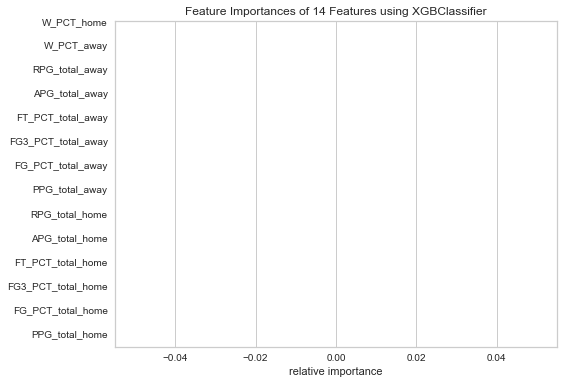

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'gamma': 20}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2307
           1       0.00      0.00      0.00      2404

    accuracy                           0.49      4711
   macro avg       0.24      0.50      0.33      4711
weighted avg       0.24      0.49      0.32      4711



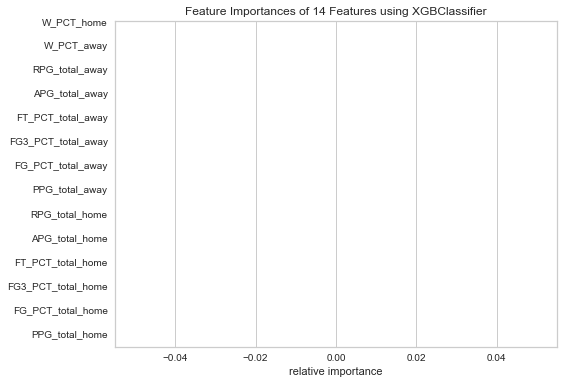

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'gamma': 21}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2419
           1       0.49      1.00      0.65      2291

    accuracy                           0.49      4710
   macro avg       0.24      0.50      0.33      4710
weighted avg       0.24      0.49      0.32      4710



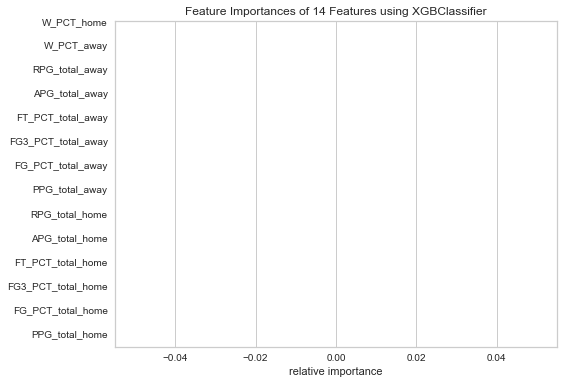

---------------------------------------------
Mean accuracy: 0.49066015707917643
Max accuracy: 0.4979834430057313
Min accuracy: 0.48482275525366164
i=15
FT:

Best XGBoost accuracy ({'gamma': 15}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2337
           1       0.00      0.00      0.00      2345

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



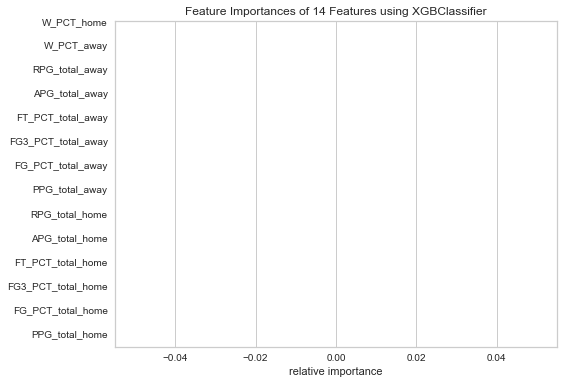

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'gamma': 25}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2322
           1       0.00      0.00      0.00      2360

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



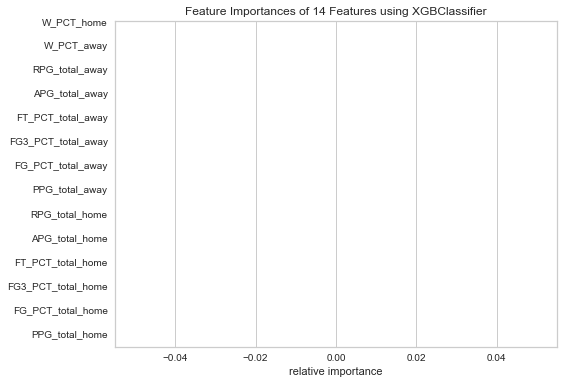

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'gamma': 27}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2360
           1       0.50      1.00      0.66      2322

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



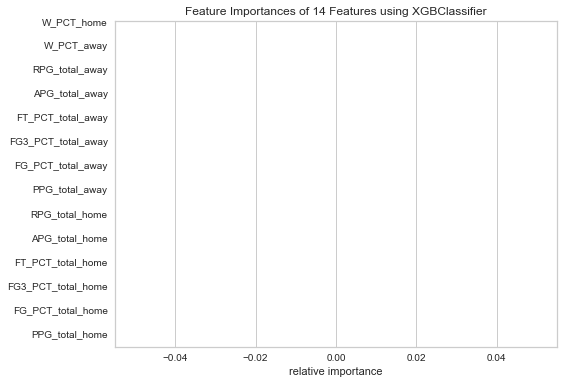

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'gamma': 15}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.83      0.63      2343
           1       0.51      0.17      0.26      2339

    accuracy                           0.50      4682
   macro avg       0.51      0.50      0.44      4682
weighted avg       0.51      0.50      0.44      4682



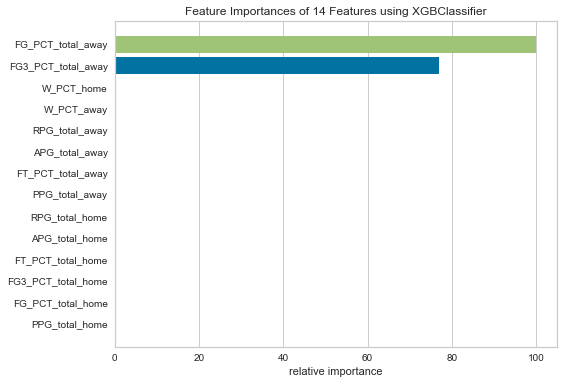

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'gamma': 22}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2343
           1       0.50      1.00      0.67      2339

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



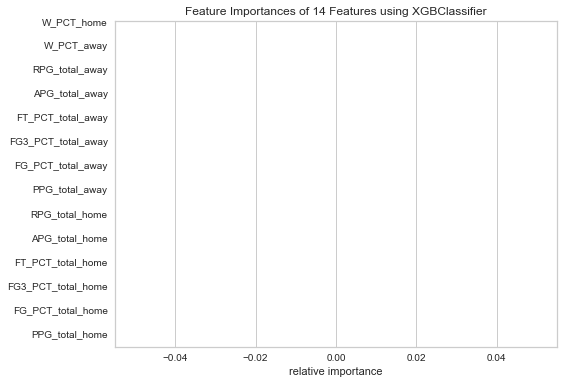

---------------------------------------------
Mean accuracy: 0.49882528833831696
Max accuracy: 0.5042716787697565
Min accuracy: 0.4959419051687313
i=20
AST:

Best XGBoost accuracy ({'gamma': 28}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2556
           1       0.50      1.00      0.67      2540

    accuracy                           0.50      5096
   macro avg       0.25      0.50      0.33      5096
weighted avg       0.25      0.50      0.33      5096



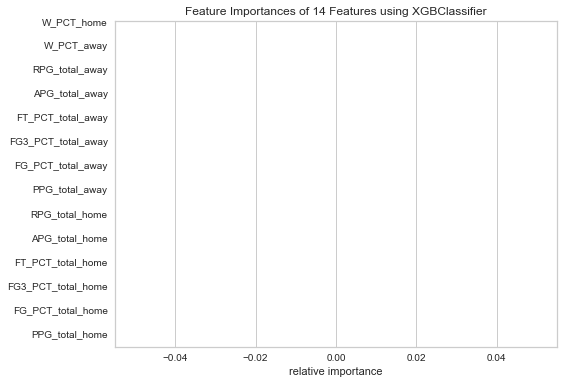

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'gamma': 1}): 0.53
              precision    recall  f1-score   support

           0       0.54      0.55      0.54      2578
           1       0.53      0.52      0.52      2517

    accuracy                           0.53      5095
   macro avg       0.53      0.53      0.53      5095
weighted avg       0.53      0.53      0.53      5095



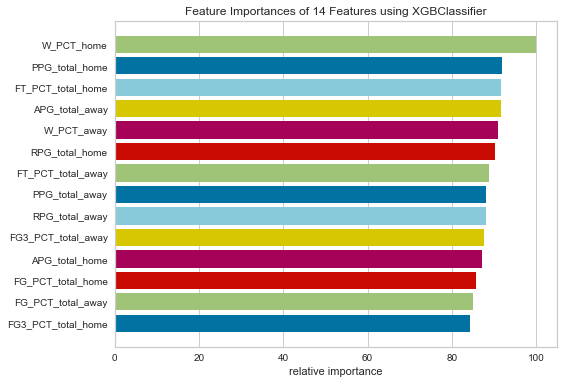

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'gamma': 26}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2522
           1       0.00      0.00      0.00      2573

    accuracy                           0.49      5095
   macro avg       0.25      0.50      0.33      5095
weighted avg       0.25      0.49      0.33      5095



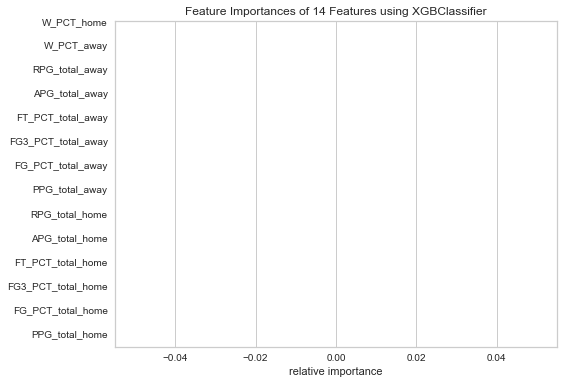

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'gamma': 25}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2531
           1       0.00      0.00      0.00      2564

    accuracy                           0.50      5095
   macro avg       0.25      0.50      0.33      5095
weighted avg       0.25      0.50      0.33      5095



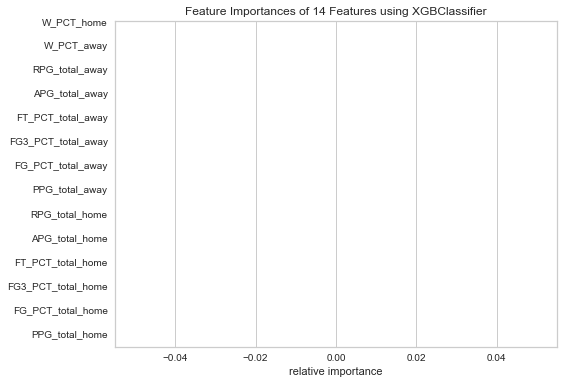

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'gamma': 26}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2551
           1       0.50      1.00      0.67      2544

    accuracy                           0.50      5095
   macro avg       0.25      0.50      0.33      5095
weighted avg       0.25      0.50      0.33      5095



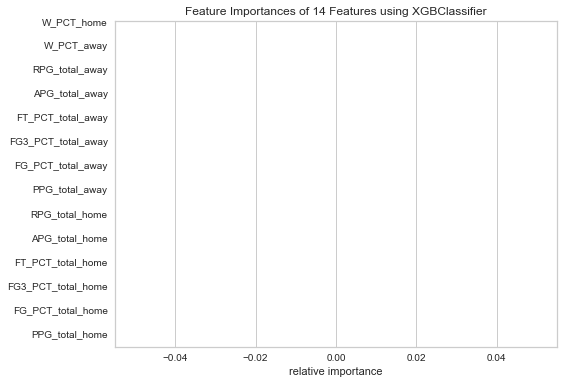

---------------------------------------------
Mean accuracy: 0.5060599396397798
Max accuracy: 0.5340529931305201
Min accuracy: 0.49499509322865554
i=25
REB:

Best XGBoost accuracy ({'gamma': 25}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2470
           1       0.00      0.00      0.00      2475

    accuracy                           0.50      4945
   macro avg       0.25      0.50      0.33      4945
weighted avg       0.25      0.50      0.33      4945



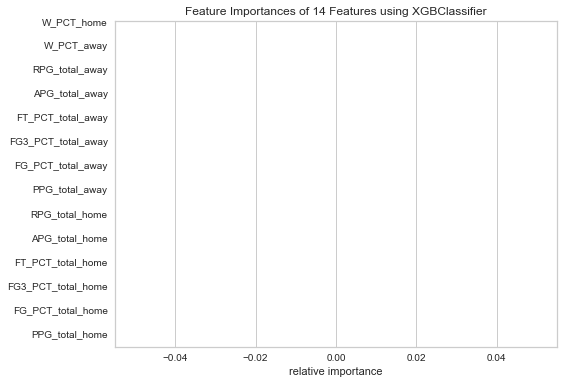

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'gamma': 23}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2413
           1       0.00      0.00      0.00      2532

    accuracy                           0.49      4945
   macro avg       0.24      0.50      0.33      4945
weighted avg       0.24      0.49      0.32      4945



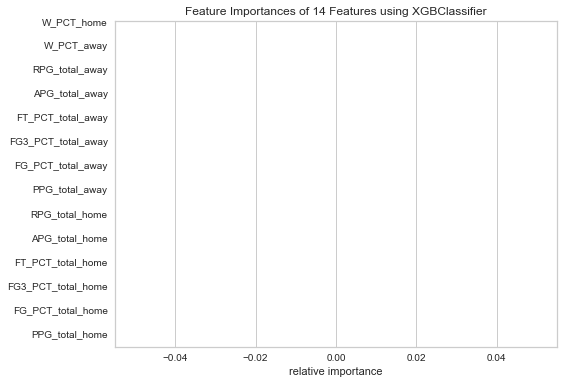

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'gamma': 29}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2479
           1       0.50      1.00      0.67      2465

    accuracy                           0.50      4944
   macro avg       0.25      0.50      0.33      4944
weighted avg       0.25      0.50      0.33      4944



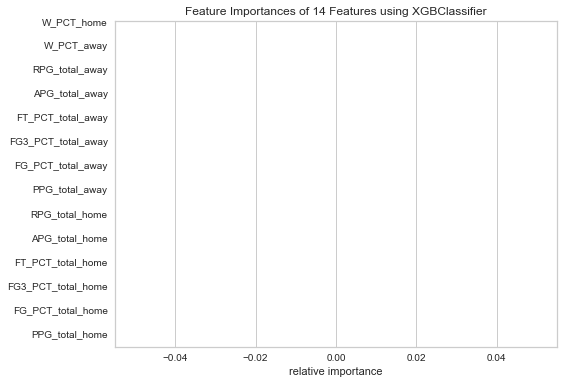

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'gamma': 24}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2473
           1       0.50      1.00      0.67      2471

    accuracy                           0.50      4944
   macro avg       0.25      0.50      0.33      4944
weighted avg       0.25      0.50      0.33      4944



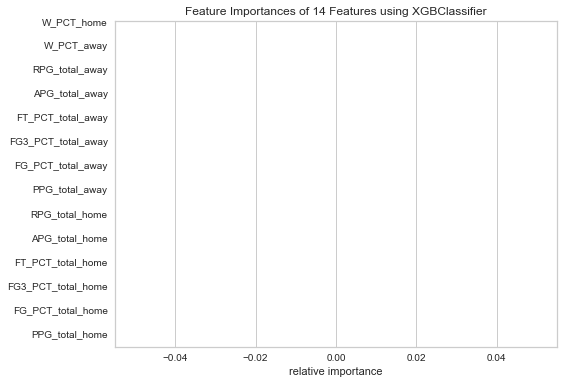

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'gamma': 21}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2526
           1       0.49      1.00      0.66      2418

    accuracy                           0.49      4944
   macro avg       0.24      0.50      0.33      4944
weighted avg       0.24      0.49      0.32      4944



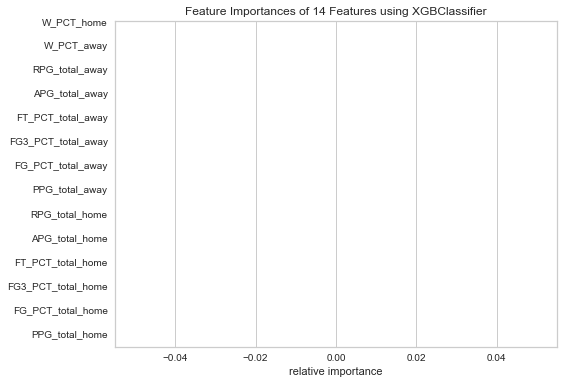

---------------------------------------------
Mean accuracy: 0.49646098998367155
Max accuracy: 0.4997977346278317
Min accuracy: 0.48796764408493426


In [28]:
# Minimum loss reduction required to make a further partition on a leaf node of the tree. 
# The larger gamma is, the more conservative the algorithm will be.

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'gamma' : [*range(0,30)],
})

## Try prune scale_pos_weight

i=0
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 29}): 0.52
              precision    recall  f1-score   support

           0       0.68      0.04      0.08      2695
           1       0.51      0.98      0.67      2789

    accuracy                           0.52      5484
   macro avg       0.60      0.51      0.38      5484
weighted avg       0.60      0.52      0.38      5484



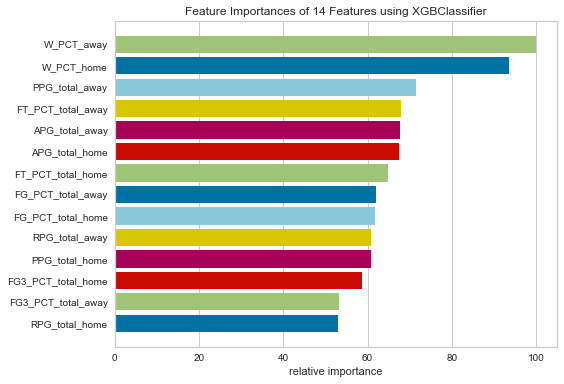

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 29}): 0.51
              precision    recall  f1-score   support

           0       0.71      0.04      0.08      2780
           1       0.50      0.98      0.66      2704

    accuracy                           0.51      5484
   macro avg       0.60      0.51      0.37      5484
weighted avg       0.60      0.51      0.37      5484



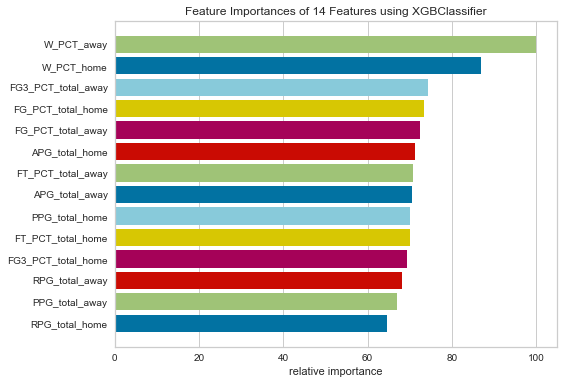

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2727
           1       0.00      0.00      0.00      2757

    accuracy                           0.50      5484
   macro avg       0.25      0.50      0.33      5484
weighted avg       0.25      0.50      0.33      5484



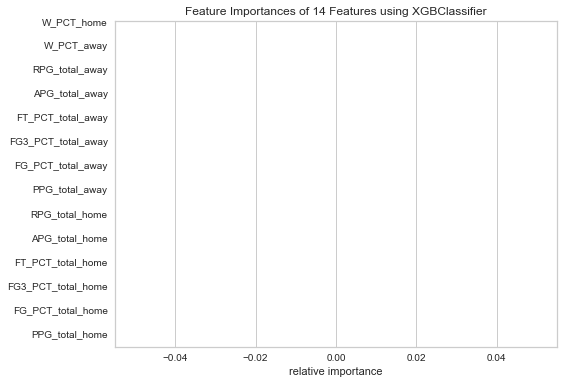

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2715
           1       0.00      0.00      0.00      2768

    accuracy                           0.50      5483
   macro avg       0.25      0.50      0.33      5483
weighted avg       0.25      0.50      0.33      5483



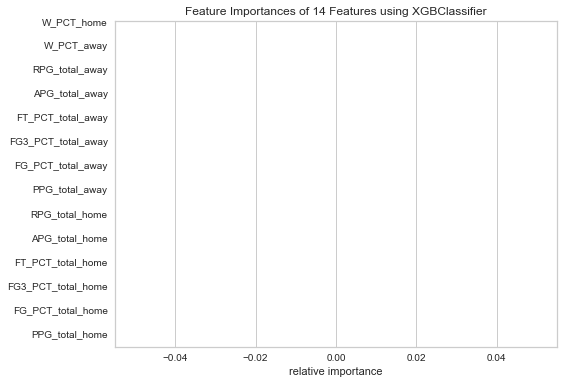

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 20}): 0.50
              precision    recall  f1-score   support

           0       0.67      0.05      0.09      2792
           1       0.50      0.98      0.66      2691

    accuracy                           0.50      5483
   macro avg       0.58      0.51      0.37      5483
weighted avg       0.59      0.50      0.37      5483



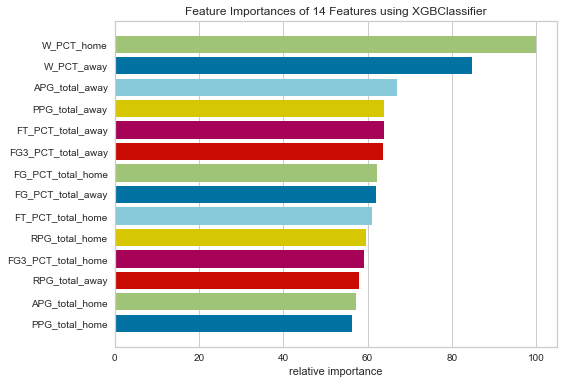

---------------------------------------------
Mean accuracy: 0.5045357023559193
Max accuracy: 0.5195113056163384
Min accuracy: 0.495166879445559
i=5
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 28}): 0.50
              precision    recall  f1-score   support

           0       0.63      0.04      0.07      2614
           1       0.49      0.98      0.65      2495

    accuracy                           0.50      5109
   macro avg       0.56      0.51      0.36      5109
weighted avg       0.56      0.50      0.35      5109



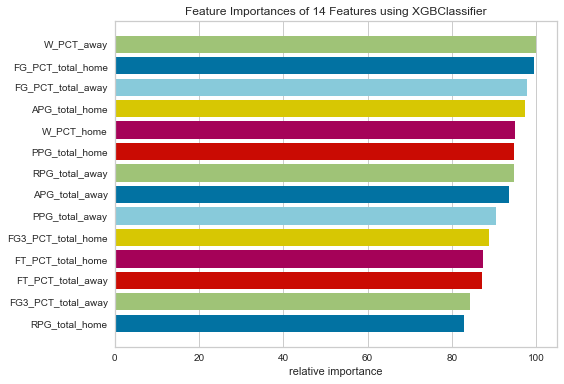

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 27}): 0.50
              precision    recall  f1-score   support

           0       0.59      0.04      0.07      2571
           1       0.50      0.97      0.66      2538

    accuracy                           0.50      5109
   macro avg       0.54      0.51      0.37      5109
weighted avg       0.54      0.50      0.36      5109



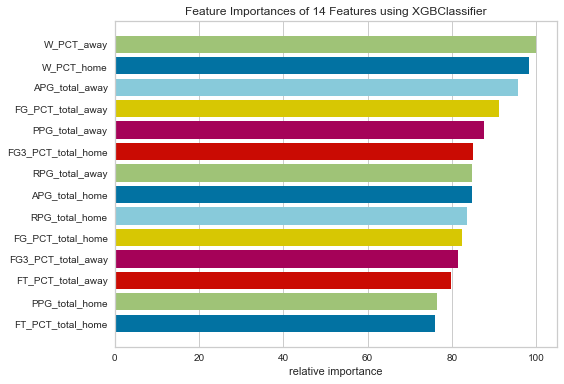

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2559
           1       0.00      0.00      0.00      2549

    accuracy                           0.50      5108
   macro avg       0.25      0.50      0.33      5108
weighted avg       0.25      0.50      0.33      5108



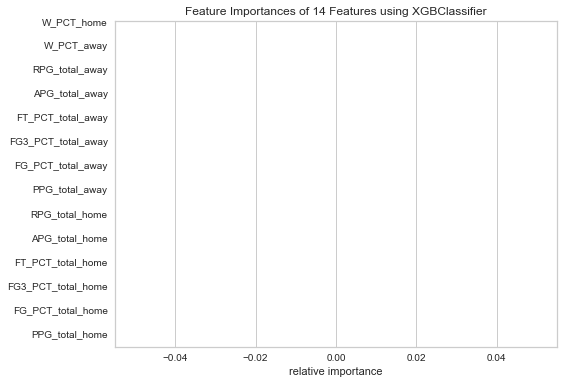

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 26}): 0.52
              precision    recall  f1-score   support

           0       0.55      0.04      0.08      2470
           1       0.52      0.97      0.68      2638

    accuracy                           0.52      5108
   macro avg       0.54      0.50      0.38      5108
weighted avg       0.53      0.52      0.39      5108



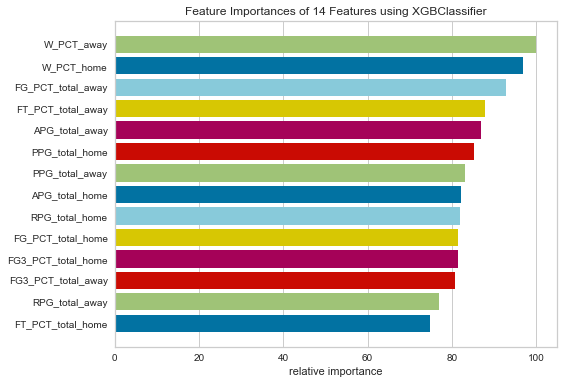

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 22}): 0.51
              precision    recall  f1-score   support

           0       0.61      0.04      0.07      2557
           1       0.50      0.98      0.66      2551

    accuracy                           0.51      5108
   macro avg       0.56      0.51      0.37      5108
weighted avg       0.56      0.51      0.37      5108



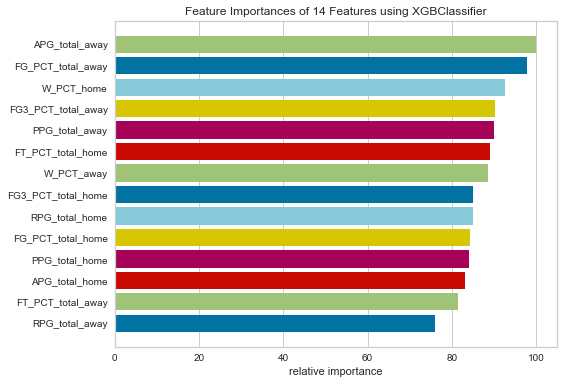

---------------------------------------------
Mean accuracy: 0.50494329336977
Max accuracy: 0.5201644479248239
Min accuracy: 0.4961832061068702
i=10
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 9}): 0.50
              precision    recall  f1-score   support

           0       0.46      0.04      0.07      2365
           1       0.50      0.96      0.65      2346

    accuracy                           0.50      4711
   macro avg       0.48      0.50      0.36      4711
weighted avg       0.48      0.50      0.36      4711



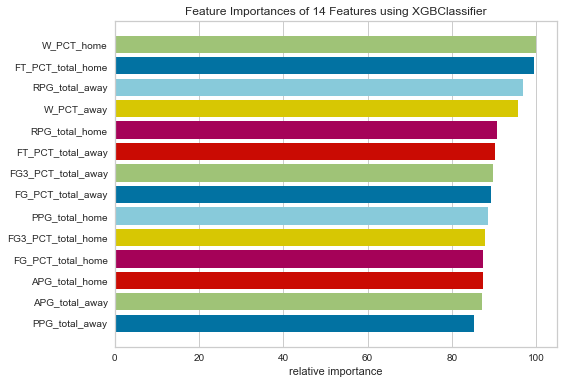

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 14}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.04      0.07      2402
           1       0.49      0.96      0.65      2309

    accuracy                           0.49      4711
   macro avg       0.49      0.50      0.36      4711
weighted avg       0.49      0.49      0.36      4711



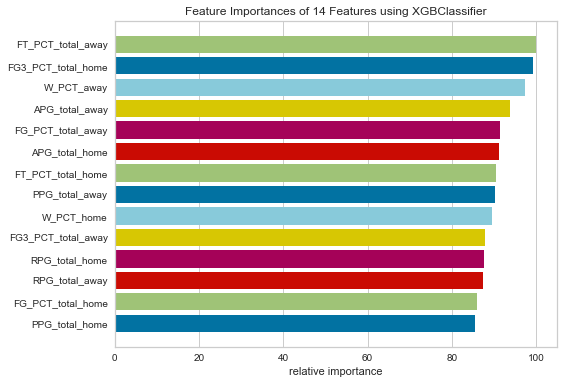

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 16}): 0.52
              precision    recall  f1-score   support

           0       0.56      0.05      0.10      2284
           1       0.52      0.96      0.67      2427

    accuracy                           0.52      4711
   macro avg       0.54      0.51      0.38      4711
weighted avg       0.54      0.52      0.39      4711



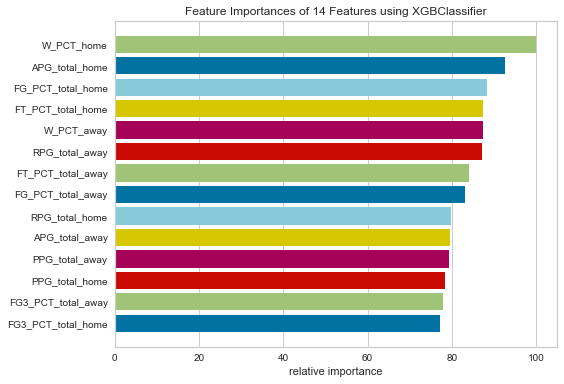

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 26}): 0.51
              precision    recall  f1-score   support

           0       0.49      0.03      0.06      2307
           1       0.51      0.97      0.67      2404

    accuracy                           0.51      4711
   macro avg       0.50      0.50      0.36      4711
weighted avg       0.50      0.51      0.37      4711



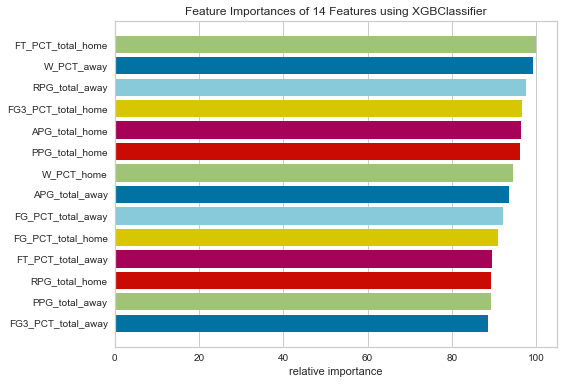

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 18}): 0.49
              precision    recall  f1-score   support

           0       0.51      0.03      0.06      2419
           1       0.49      0.97      0.65      2291

    accuracy                           0.49      4710
   macro avg       0.50      0.50      0.36      4710
weighted avg       0.50      0.49      0.35      4710



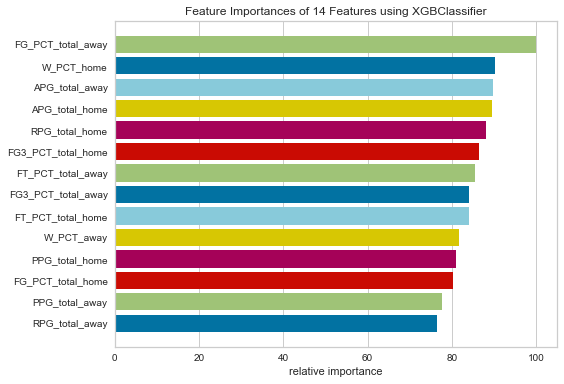

---------------------------------------------
Mean accuracy: 0.5035024410953088
Max accuracy: 0.5202717045213331
Min accuracy: 0.48906813839949054
i=15
FT:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2337
           1       0.00      0.00      0.00      2345

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



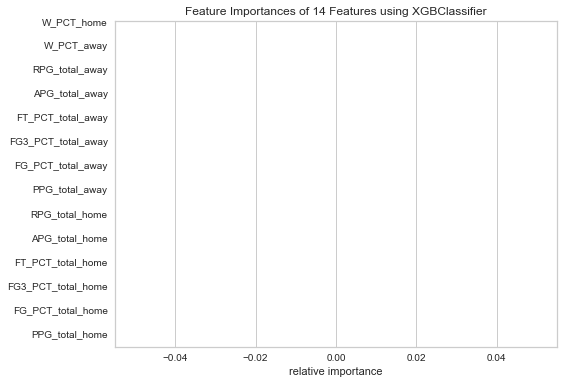

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'scale_pos_weight': 18}): 0.50
              precision    recall  f1-score   support

           0       0.48      0.04      0.07      2322
           1       0.50      0.96      0.66      2360

    accuracy                           0.50      4682
   macro avg       0.49      0.50      0.36      4682
weighted avg       0.49      0.50      0.37      4682



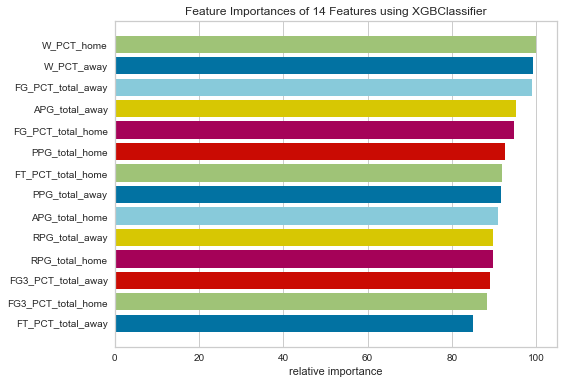

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'scale_pos_weight': 9}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.06      0.10      2360
           1       0.49      0.94      0.65      2322

    accuracy                           0.49      4682
   macro avg       0.49      0.50      0.37      4682
weighted avg       0.49      0.49      0.37      4682



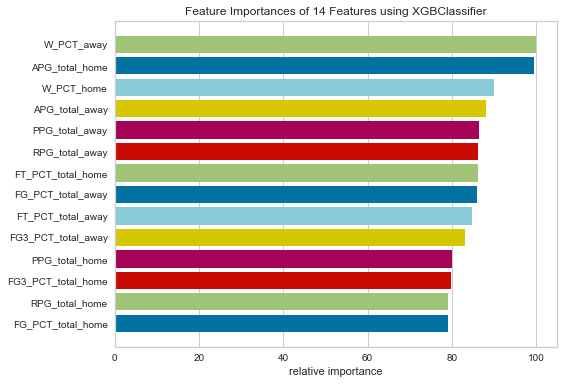

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'scale_pos_weight': 28}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.03      0.06      2343
           1       0.50      0.97      0.66      2339

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.36      4682
weighted avg       0.50      0.50      0.36      4682



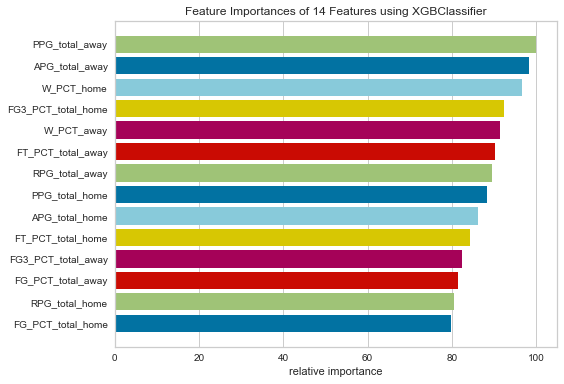

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2343
           1       0.00      0.00      0.00      2339

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



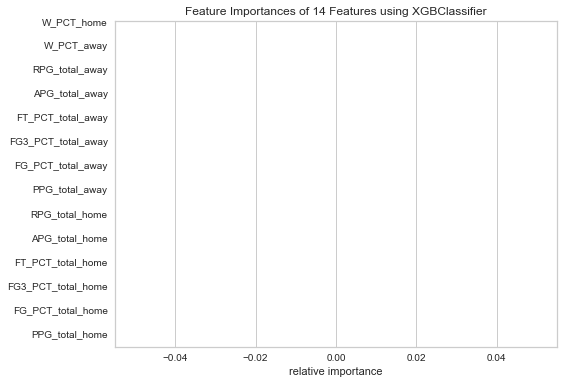

---------------------------------------------
Mean accuracy: 0.4988786843229389
Max accuracy: 0.5027765912003417
Min accuracy: 0.4944468175993165
i=20
AST:

Best XGBoost accuracy ({'scale_pos_weight': 25}): 0.50
              precision    recall  f1-score   support

           0       0.58      0.03      0.05      2556
           1       0.50      0.98      0.66      2540

    accuracy                           0.50      5096
   macro avg       0.54      0.50      0.36      5096
weighted avg       0.54      0.50      0.36      5096



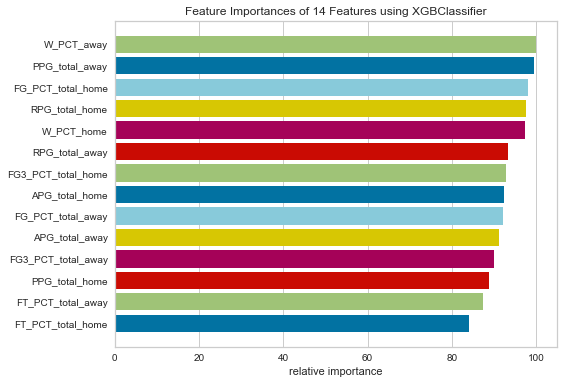

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'scale_pos_weight': 23}): 0.49
              precision    recall  f1-score   support

           0       0.51      0.03      0.06      2578
           1       0.49      0.97      0.65      2517

    accuracy                           0.49      5095
   macro avg       0.50      0.50      0.36      5095
weighted avg       0.50      0.49      0.35      5095



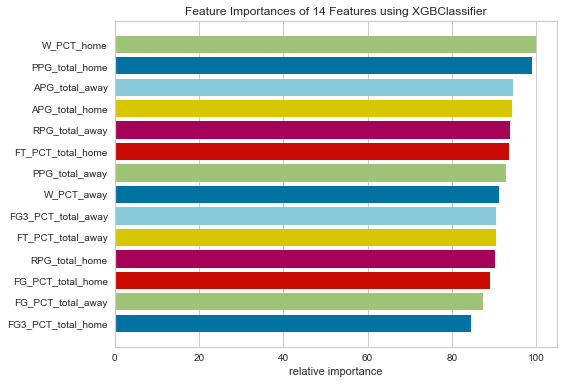

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'scale_pos_weight': 24}): 0.51
              precision    recall  f1-score   support

           0       0.54      0.03      0.06      2522
           1       0.51      0.97      0.67      2573

    accuracy                           0.51      5095
   macro avg       0.52      0.50      0.36      5095
weighted avg       0.52      0.51      0.37      5095



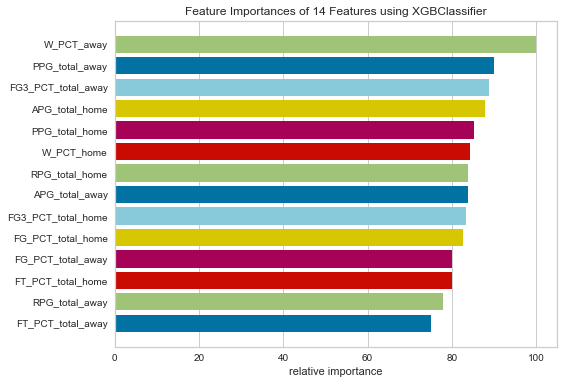

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'scale_pos_weight': 24}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.03      0.06      2531
           1       0.50      0.97      0.66      2564

    accuracy                           0.50      5095
   macro avg       0.50      0.50      0.36      5095
weighted avg       0.50      0.50      0.36      5095



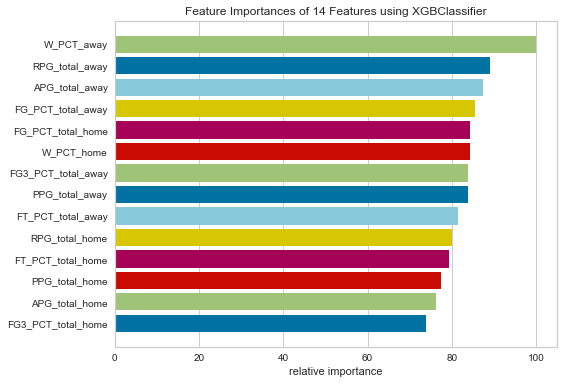

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'scale_pos_weight': 26}): 0.50
              precision    recall  f1-score   support

           0       0.55      0.03      0.07      2551
           1       0.50      0.97      0.66      2544

    accuracy                           0.50      5095
   macro avg       0.52      0.50      0.36      5095
weighted avg       0.52      0.50      0.36      5095



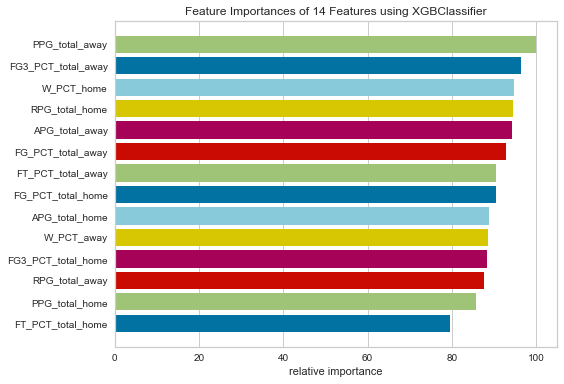

---------------------------------------------
Mean accuracy: 0.5016927301984431
Max accuracy: 0.507360157016683
Min accuracy: 0.4944062806673209
i=25
REB:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2470
           1       0.00      0.00      0.00      2475

    accuracy                           0.50      4945
   macro avg       0.25      0.50      0.33      4945
weighted avg       0.25      0.50      0.33      4945



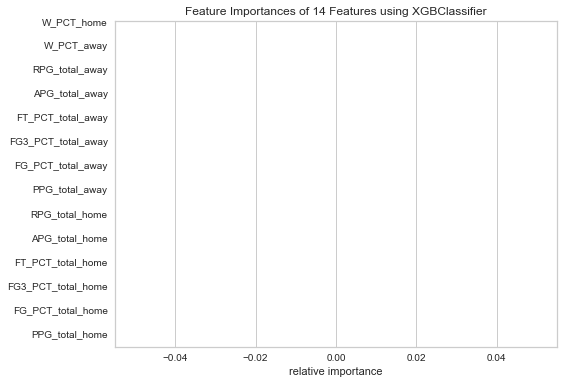

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2413
           1       0.00      0.00      0.00      2532

    accuracy                           0.49      4945
   macro avg       0.24      0.50      0.33      4945
weighted avg       0.24      0.49      0.32      4945



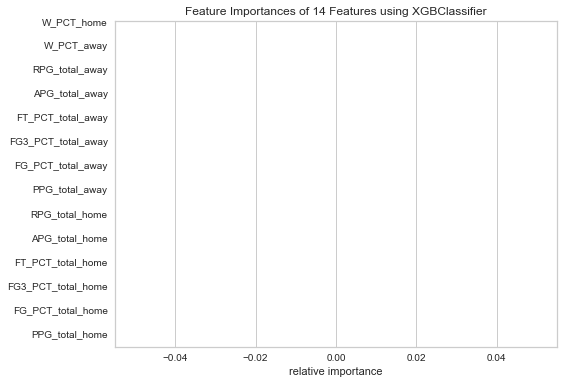

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2479
           1       0.00      0.00      0.00      2465

    accuracy                           0.50      4944
   macro avg       0.25      0.50      0.33      4944
weighted avg       0.25      0.50      0.33      4944



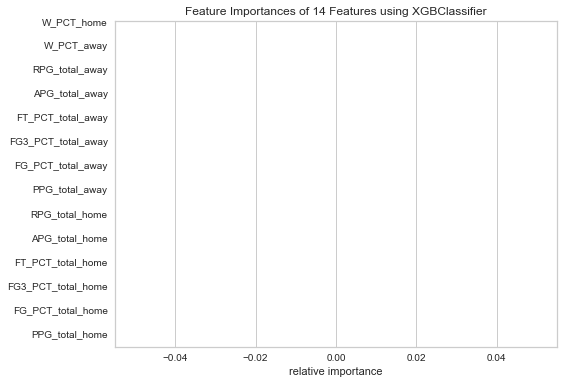

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2473
           1       0.00      0.00      0.00      2471

    accuracy                           0.50      4944
   macro avg       0.25      0.50      0.33      4944
weighted avg       0.25      0.50      0.33      4944



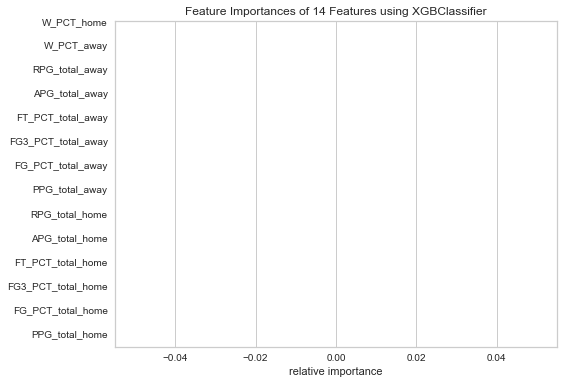

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'scale_pos_weight': 21}): 0.49
              precision    recall  f1-score   support

           0       0.60      0.03      0.06      2526
           1       0.49      0.98      0.65      2418

    accuracy                           0.49      4944
   macro avg       0.55      0.50      0.36      4944
weighted avg       0.55      0.49      0.35      4944



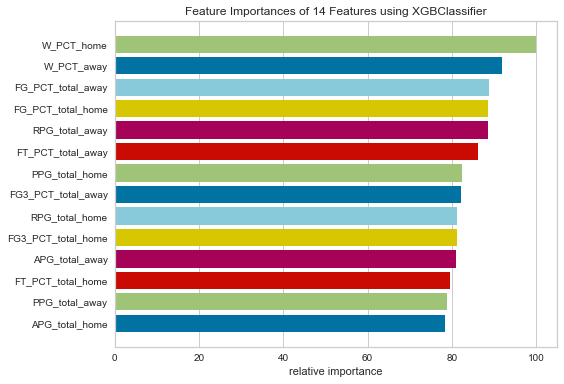

---------------------------------------------
Mean accuracy: 0.49727005147234465
Max accuracy: 0.501415857605178
Min accuracy: 0.48796764408493426


In [29]:
# Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative instances) / sum(positive instances).

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'scale_pos_weight' : [*range(0,30)],
})